# CCF analysis from callings from platinum pipeline
### Patients1-11

In [1]:
import pandas as pd
import json
import pybedtools
from tqdm.notebook import trange, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
%matplotlib inline 

In [2]:
samples = json.load( open( "/workspace/projects/sjd_pediatric_tumors/code/sample_ids.json", "rb" ) )

## Functions

In [66]:
def cnv_snvs_intersect (cnv_df,snvs_df,caller_cn):
    '''Adds CN information in snvs/indels mafs
    input: cn dataframe from ASCAT output (.cnvs.txt) and snvs/indels dataframe from maf files
    output: dataframe with integrated CN info to vc mafs'''
    
    if caller_cn == 'ascat':
        cnv_bt_df = cnv_df.copy(deep=True)
        cnv_bt_df['CN'] = cnv_bt_df['nMajor']+cnv_bt_df['nMinor']
        cnv_bt_df['chr'] = 'chr' + cnv_bt_df['chr']
        cnv_bt_df = cnv_bt_df.rename(columns={'chr':'chrom','startpos':'start','endpos':'end'})
        cnv_bt_df = cnv_bt_df[['chrom','start','end','CN']]
    elif caller_cn == 'purple':
        cnv_bt_df = cnv_df.copy(deep=True)
        cnv_bt_df = cnv_bt_df.rename(columns={'chromosome':'chrom','copyNumber':'CN'})
        cnv_bt_df = cnv_bt_df[['chrom','start','end','CN']]
    #Prepare snvs_df
    snvs_bt_df = snvs_df.copy(deep=True)
    snvs_bt_df['POS2'] = snvs_bt_df['POS'] + 1
    snvs_bt_df = snvs_bt_df[['#CHROM','POS','POS2','REF','ALT']]

    #pybedtools cnv + snvs
    cnv_bt = pybedtools.BedTool.from_dataframe(cnv_bt_df)
    snvs_bt = pybedtools.BedTool.from_dataframe(snvs_bt_df)

    cnv_and_snvs = cnv_bt.intersect(snvs_bt)

    #Pass intersection to dataframe
    snvs_cnv_df = cnv_and_snvs.to_dataframe(header=None)
    columns= ['#CHROM','POS','POS2','CN'] 
    snvs_cnv_df = snvs_cnv_df.rename(columns={'chrom':'#CHROM','start':'POS','end':'POS2',
                                              'name':'CN'})
    snvs_cnv_df = snvs_cnv_df.drop(columns=['POS2'])

    #Merge intersect with snvs_df
    snvs_cnv_df = pd.merge(snvs_df,snvs_cnv_df,how='left')
    
    return snvs_cnv_df

def calculate_VAF(reads_alt,reads_ref):
    '''Calculate VAF from number of reads
    input: number of reads alternate allele, number of reads reference allele
    output: variant allele frequency'''
    if reads_alt == reads_ref == 0:
        return 0
    else:
        vaf = round (reads_alt/(reads_alt+reads_ref),3)
        return vaf

def calculate_ccf (vaf,cnv,purity):
    '''Calculate CCF from VAF, CN and purity
    input: variant allele frequency, copy number, purity(.purityploidy.txt file from ASCAT)
    output: cancer cell fraction'''
    ccf = vaf*(purity*cnv+ (1-purity)*2)/purity
    return ccf

def final_dataframe (pt,tumor,normal,vc,t,purity='purple',cnv_file='purple'):
    '''Reads vc mafs and ASCAT output, makes intersect snvs and CN and adds columns calculated 
    with VAF and CCF
    input: patient, tumor sample id, normal sample id and caller type
    output: final dataframe with CN, VAF and CCF information added'''
    
    #Read cnv callings (ascat or purple)
    if cnv_file == 'ascat':
        cnv_df = pd.read_csv('/workspace/datasets/sjd_seq/platinum_results/20220809/'
                         +pt+'-'+t+'-allsamples-'+t+'/sarek_results/results/variant_calling/ascat/'
                         +tumor+'_vs_'+normal+'/'+tumor+'_vs_'+normal+'.cnvs.txt',sep='\t')  
    elif cnv_file == 'purple':
        cnv_df = pd.read_csv('/workspace/datasets/sjd_seq/platinum_results/20220809/'
                         +pt+'-'+t+'-allsamples-'+t+'/purple/'+tumor+'.purple.cnv.somatic.tsv',sep='\t')          
    else:
        print('Specify cnv_file: purple or ascat')
        
    if purity == 'ascat':
        purity = pd.read_csv('/workspace/datasets/sjd_seq/platinum_results/20220809/'
                             +pt+'-'+t+'-allsamples-'+t+'/sarek_results/results/variant_calling/ascat/'
                             +tumor+'_vs_'+normal+'/'+tumor+'_vs_'+normal+'.purityploidy.txt',sep='\t')
        #Get purity
        purity = purity['AberrantCellFraction'][0]
    elif purity == 'purple':
        purity = pd.read_csv('/workspace/datasets/sjd_seq/platinum_results/20220809/'
                             +pt+'-'+t+'-allsamples-'+t+'/purple/'
                             +tumor+'.purple.purity.tsv',sep='\t')
        #Get purity
        purity = purity['purity'][0]
    
    if vc == 'mutect':
        snvs_df = pd.read_csv('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/'
                              +pt+'/'+tumor+'_vs_'+normal+'/vcf_processing/mutect/'
                              +tumor+'_vs_'+normal+'_process.maf.gz',sep='\t')
    elif vc =='strelka':
        snvs_df = pd.read_csv('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/'
                              +pt+'/'+tumor+'_vs_'+normal+'/vcf_processing/strelka/'
                              +tumor+'_vs_'+normal+'_process.maf.gz',sep='\t')
    elif vc == 'sage':
        snvs_df = pd.read_csv('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/'
                              +pt+'/'+tumor+'_vs_'+normal+'/vcf_processing/sage/'
                              +tumor+'_vs_'+normal+'_process.maf.gz',sep='\t')
    elif vc == 'intersect':
        snvs_df = pd.read_csv('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/'
                              +pt+'/'+tumor+'_vs_'+normal+'/process_vep_output/'
                              +tumor+'_vs_'+normal+'.maf.gz',sep='\t')
    else:
        print('Specify variant caller: mutect, strelka, sage')
    
    #Get df with cn and snv intersect
    
    if 'purple' in cnv_file:
        caller_cn = 'purple'
    else:
        caller_cn = 'ascat'
    df = cnv_snvs_intersect(cnv_df,snvs_df,caller_cn)    

    
    #Calculate AF and CCF
    df['t_AF'] = df.apply(lambda row: calculate_VAF(row['t_alt_reads'],row['t_ref_reads']),axis=1)
    df['n_AF'] = df.apply(lambda row: calculate_VAF(row['n_alt_reads'],row['n_ref_reads']),axis=1)
    df['t_CCF'] = df.apply(lambda row: calculate_ccf(row['t_AF'],row['CN'],purity),axis=1)
    df['n_CCF'] = df.apply(lambda row: calculate_ccf(row['n_AF'],row['CN'],purity),axis=1)
    df['purity'] = purity
    
    return df

In [63]:
pt = 'pt5'
tumor = 'AQ5190'
normal = 'AQ5178'
# '/workspace/datasets/sjd_seq/platinum_results/20220809/pt1-t1-allsamples-t1/purple/AQ5180.purple.purity.tsv'
purity = pd.read_csv('/workspace/datasets/sjd_seq/platinum_results/20220809/'
                     +pt+'-t2-allsamples-t2'+'/purple/'
                     +tumor+'.purple.purity.tsv',sep='\t')

#Get purity
purity 
purity['purity'][0]

0.33

### Patient 1

In [67]:
#Tumor1

pt = 'pt1'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
pt1_t1_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t1')
pt1_t1_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t1')
pt1_t1_sage_df = final_dataframe(pt,tumor,normal,'sage','t1')
pt1_t1_df = final_dataframe(pt,tumor,normal,'intersect','t1')

#Tumor2
tumor = samples[pt]['tumor2']
pt1_t2_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t2')
pt1_t2_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t2')
pt1_t2_sage_df = final_dataframe(pt,tumor,normal,'sage','t2')
pt1_t2_df = final_dataframe(pt,tumor,normal,'intersect','t2')

### Patient 2

In [68]:
#Tumor1
pt = 'pt2'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
pt2_t1_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t1')
pt2_t1_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t1')
pt2_t1_sage_df = final_dataframe(pt,tumor,normal,'sage','t1')
pt2_t1_df = final_dataframe(pt,tumor,normal,'intersect','t1')

#Tumor2
tumor = samples[pt]['tumor2']
pt2_t2_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t2')
pt2_t2_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t2')
pt2_t2_sage_df = final_dataframe(pt,tumor,normal,'sage','t2')
pt2_t2_df = final_dataframe(pt,tumor,normal,'intersect','t2')

### Patient 3

In [69]:
#Tumor1
pt = 'pt3'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
pt3_t1_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t1')
pt3_t1_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t1')
pt3_t1_sage_df = final_dataframe(pt,tumor,normal,'sage','t1')
pt3_t1_df = final_dataframe(pt,tumor,normal,'intersect','t1')

#Tumor2
tumor = samples[pt]['tumor2']
pt3_t2_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t2')
pt3_t2_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t2')
pt3_t2_sage_df = final_dataframe(pt,tumor,normal,'sage','t2')
pt3_t2_df = final_dataframe(pt,tumor,normal,'intersect','t2')

### Patient 4

In [70]:
#Tumor1
pt = 'pt4'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
pt4_t1_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t1')
pt4_t1_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t1')
pt4_t1_sage_df = final_dataframe(pt,tumor,normal,'sage','t1')
pt4_t1_df = final_dataframe(pt,tumor,normal,'intersect','t1')

#Tumor2
tumor = samples[pt]['tumor2']
pt4_t2_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t2')
pt4_t2_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t2')
pt4_t2_sage_df = final_dataframe(pt,tumor,normal,'sage','t2')
pt4_t2_df = final_dataframe(pt,tumor,normal,'intersect','t2')

### Patient 5

In [71]:
#Tumor1
pt = 'pt5'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
pt5_t1_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t1')
pt5_t1_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t1')
pt5_t1_sage_df = final_dataframe(pt,tumor,normal,'sage','t1')
pt5_t1_df = final_dataframe(pt,tumor,normal,'intersect','t1')

#Tumor2
tumor = samples[pt]['tumor2']
pt5_t2_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t2')
pt5_t2_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t2')
pt5_t2_sage_df = final_dataframe(pt,tumor,normal,'sage','t2')
pt5_t2_df = final_dataframe(pt,tumor,normal,'intersect','t2')

### Patient 6

In [72]:
#Tumor1
pt = 'pt6'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
pt6_t1_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t1')
pt6_t1_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t1')
pt6_t1_sage_df = final_dataframe(pt,tumor,normal,'sage','t1')
pt6_t1_df = final_dataframe(pt,tumor,normal,'intersect','t1')

#Tumor2
tumor = samples[pt]['tumor2']
pt6_t2_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t2')
pt6_t2_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t2')
pt6_t2_sage_df = final_dataframe(pt,tumor,normal,'sage','t2')
pt6_t2_df = final_dataframe(pt,tumor,normal,'intersect','t2')

### Patient 7

In [73]:
#Tumor1
pt = 'pt7'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
pt7_t1_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t1')
pt7_t1_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t1')
pt7_t1_sage_df = final_dataframe(pt,tumor,normal,'sage','t1')
pt7_t1_df = final_dataframe(pt,tumor,normal,'intersect','t1')

#Tumor2
tumor = samples[pt]['tumor2']
pt7_t2_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t2')
pt7_t2_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t2')
pt7_t2_sage_df = final_dataframe(pt,tumor,normal,'sage','t2')
pt7_t2_df = final_dataframe(pt,tumor,normal,'intersect','t2')

### Patient 8

In [74]:
#Tumor1
pt = 'pt8'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
pt8_t1_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t1')
pt8_t1_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t1')
pt8_t1_sage_df = final_dataframe(pt,tumor,normal,'sage','t1')
pt8_t1_df = final_dataframe(pt,tumor,normal,'intersect','t1')

#Tumor2
tumor = samples[pt]['tumor2']
pt8_t2_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t2')
pt8_t2_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t2')
pt8_t2_sage_df = final_dataframe(pt,tumor,normal,'sage','t2')
pt8_t2_df = final_dataframe(pt,tumor,normal,'intersect','t2')

### Patient 10

In [75]:
#Tumor1
pt = 'pt10'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
pt10_t1_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t1')
pt10_t1_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t1')
pt10_t1_sage_df = final_dataframe(pt,tumor,normal,'sage','t1')
pt10_t1_df = final_dataframe(pt,tumor,normal,'intersect','t1')

#Tumor2
tumor = samples[pt]['tumor2']
pt10_t2_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t2')
pt10_t2_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t2')
pt10_t2_sage_df = final_dataframe(pt,tumor,normal,'sage','t2')
pt10_t2_df = final_dataframe(pt,tumor,normal,'intersect','t2')

### Patient 11

In [76]:
#Tumor1
pt = 'pt11'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
pt11_t1_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t1')
pt11_t1_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t1')
pt11_t1_sage_df = final_dataframe(pt,tumor,normal,'sage','t1')
pt11_t1_df = final_dataframe(pt,tumor,normal,'intersect','t1')

#Tumor2
tumor = samples[pt]['tumor2']
pt11_t2_mutect_df = final_dataframe(pt,tumor,normal,'mutect','t2')
pt11_t2_strelka_df = final_dataframe(pt,tumor,normal,'strelka','t2')
pt11_t2_sage_df = final_dataframe(pt,tumor,normal,'sage','t2')
pt11_t2_df = final_dataframe(pt,tumor,normal,'intersect','t2')

In [77]:
pt11_t2_mutect_df.columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'NORMAL', 'TUMOR', 't_AF', 'n_AF', 'DP_tumor', 't_alt_reads',
       't_ref_reads', 'DP_normal', 'n_alt_reads', 'n_ref_reads', 'mut_type',
       'GT_normal', 'GT_tumor', 'CN', 't_CCF', 'n_CCF', 'purity'],
      dtype='object')

## Plots

### Tumor mutational burden

In [16]:
import os

In [18]:
#Load St-Jude, TARGET and Hartwig datasets

#TARGET
root = '/workspace/datasets/intogen/runs/20210108/intogen_20210108/steps/inputs/'
files = os.listdir(root)
files = [file for file in files if file.startswith('TARGET')]
target_df = pd.DataFrame()
for file in tqdm(files):
    df1 = pd.read_csv(root + file, sep='\t')
    target_df = pd.concat([target_df,df1],ignore_index=True)

#St. Jude
root = '/workspace/datasets/intogen/runs/20210108/intogen_20210108/steps/inputs/'
files = os.listdir(root)
files = [file for file in files if file.startswith('D_')]
stjude_df = pd.DataFrame()
for file in tqdm(files):
    df1 = pd.read_csv(root + file, sep='\t')
    stjude_df = pd.concat([stjude_df,df1],ignore_index=True)

#Hartwig
#Get all hartwig tables with liftover (at hg38)
root = '/workspace/projects/sjd_pediatric_tumors/signatures/extraction/hartwig/'
files = os.listdir(root)
files = [file for file in files if 'HARTWIG' in file]
hartwig_df = pd.DataFrame()
for file in files:
    df = pd.read_csv(root + file,sep='\t')
    hartwig_df = pd.concat([hartwig_df,df],ignore_index=True)

In [78]:
print(len(pt1_t1_df))
print(len(pt1_t1_df[pt1_t1_df['gnomADg_AF']<0.01]))

1918
1614


In [21]:
samples_list[0]

#CHROM        POS ID     REF ALT  QUAL FILTER  \
0      chr1    3985668  .       A   -   656   PASS   
1      chr1    8139423  .       G   T   825   PASS   
2      chr1   11266002  .       T   -   247   PASS   
3      chr1   19841394  .       C   T  1048   PASS   
4      chr1   22354916  .       C   A     .   PASS   
...     ...        ... ..     ...  ..   ...    ...   
1913   chrX  150142831  .       T   -   585   PASS   
1914   chrX  152047311  .       T   -   497   PASS   
1915   chrX  152460903  .  AAATAT   -   433   PASS   
1916   chrX  152495998  .       C   A  1007   PASS   
1917   chrX  152496572  .       T   -     .   PASS   

                                                   INFO  \
0     MH=A;RC=TACAAAAAAAAAAAAAAAAAGC;RC_IDX=2;RC_LF=...   
1     LPS=1;LPS_RC=27;RC=TATCC;RC_IDX=2;RC_LF=ATACAA...   
2     MH=T;RC=TCCTTTTTTTTTTTTTTTTTTTTTTGA;RC_IDX=2;R...   
3     RC=GGTCA;RC_IDX=2;RC_LF=AGACCAGCCT;RC_NM=1;RC_...   
4     DP=174;MQ=59.90;MQ0=0;NT=ref;QSS=80;QSS_NT=80;...   
...                                                 ...   
1913  MH=T;RC=AGGTTTTTTTTTTTTTCT;RC_IDX=2;RC_LF=CAGT...   
1914  MH=T;RC=GCCTTTTTTTTTTTTTTGG;RC_IDX=2;RC_LF=AAG...   
1915  MH=A;RC=CAAAAAAAAAAAAATAT;RC_IDX=12;RC_LF=GAAT...   
1916  RC=GAAAAG;RC_IDX=3;RC_LF=ACTACCACGA;RC_NM=1;RC...   
1917  IC=9;IHP=10;MQ=60.00;MQ0=0;NT=ref;QSI=122;QSI_...   

                                                 FORMAT  \
0     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
2     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
3     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
4                          DP:FDP:SDP:SUBDP:AU:CU:GU:TU   
...                                                 ...   
1913  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1914  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1915  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1916  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1917        DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50   

                                                 NORMAL  ... gnomADg_AF  \
0     ./.:99,0:0:111:3592,0:116,0:0,0,0,0,0,99,111:0...  ...   0.346909   
1     ./.:117,0:0:117:4428,0:122,0:0,0,0,0,0,117,117...  ...   0.000000   
2     ./.:88,0:0:91:3066,0:106,0:0,0,0,0,0,88,91:0:0...  ...   0.018384   
3     ./.:110,0:0:110:4120,0:112,0:0,0,0,0,0,110,110...  ...   0.000007   
4                         117:3:0:0:0,0:113,116:1,1:0,0  ...   0.000007   
...                                                 ...  ...        ...   
1913  ./.:99,0:0:102:3509,0:105,0:0,0,0,0,0,99,102:0...  ...   0.029149   
1914  ./.:98,0:0:105:3637,0:117,0:0,0,0,0,0,98,105:0...  ...   0.017334   
1915  ./.:85,0:0:85:3256,0:90,0:0,0,0,0,0,85,85:0:0,...  ...   0.166475   
1916  ./.:132,0:0:132:5144,0:140,0:0,0,0,0,0,132,132...  ...   0.000000   
1917    145:145:131,133:3,3:11,11:138.47:1.09:0.00:0.01  ...   0.007984   

      gnomADg_NFE    subset_origin            SAMPLE  nMinor  nMajor   CN  \
0               -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     0.0  2.0   
1               -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     0.0  2.0   
2               -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     0.0  2.0   
3               -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     0.0  2.0   
4               -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     0.0  2.0   
...           ...              ...               ...     ...     ...  ...   
1913            -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     2.0  4.0   
1914            -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     2.0  4.0   
1915            -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     2.0  4.0   
1916            -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     2.0  4.0   
1917            -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     2.0  4.0   

         t_CCF     n_CCF purity  
0     1.688608  0.000000   0.79  
1     1.637975  0.000000   0.79  
2     0.86

In [79]:
samples_list = [pt1_t1_df,pt1_t2_df,
                pt2_t1_df,pt2_t2_df,
                pt3_t1_df,pt3_t2_df,
                pt4_t1_df,pt4_t2_df,
                pt5_t1_df,pt5_t2_df,
                pt6_t1_df,pt6_t2_df,
                pt7_t1_df,pt7_t2_df,
                pt8_t1_df,pt8_t2_df,
                pt10_t1_df,pt10_t2_df,
                pt11_t1_df,pt11_t2_df]

In [80]:
samples_mutect_list = [pt1_t1_mutect_df,pt1_t2_mutect_df,
                pt2_t1_mutect_df,pt2_t2_mutect_df,
                pt3_t1_mutect_df,pt3_t2_mutect_df,
                pt4_t1_mutect_df,pt4_t2_mutect_df,
                pt5_t1_mutect_df,pt5_t2_mutect_df,
                pt6_t1_mutect_df,pt6_t2_mutect_df,
                pt7_t1_mutect_df,pt7_t2_mutect_df,
                pt8_t1_mutect_df,pt8_t2_mutect_df,
                pt10_t1_mutect_df,pt10_t2_mutect_df,
                pt11_t1_mutect_df,pt11_t2_mutect_df]

In [81]:
samples_strelka_list = [pt1_t1_strelka_df,pt1_t2_strelka_df,
                pt2_t1_strelka_df,pt2_t2_strelka_df,
                pt3_t1_strelka_df,pt3_t2_strelka_df,
                pt4_t1_strelka_df,pt4_t2_strelka_df,
                pt5_t1_strelka_df,pt5_t2_strelka_df,
                pt6_t1_strelka_df,pt6_t2_strelka_df,
                pt7_t1_strelka_df,pt7_t2_strelka_df,
                pt8_t1_strelka_df,pt8_t2_strelka_df,
                pt10_t1_strelka_df,pt10_t2_strelka_df,
                pt11_t1_strelka_df,pt11_t2_strelka_df]

In [82]:
samples_sage_list = [pt1_t1_sage_df,pt1_t2_sage_df,
                pt2_t1_sage_df,pt2_t2_sage_df,
                pt3_t1_sage_df,pt3_t2_sage_df,
                pt4_t1_sage_df,pt4_t2_sage_df,
                pt5_t1_sage_df,pt5_t2_sage_df,
                pt6_t1_sage_df,pt6_t2_sage_df,
                pt7_t1_sage_df,pt7_t2_sage_df,
                pt8_t1_sage_df,pt8_t2_sage_df,
                pt10_t1_sage_df,pt10_t2_sage_df,
                pt11_t1_sage_df,pt11_t2_sage_df]

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


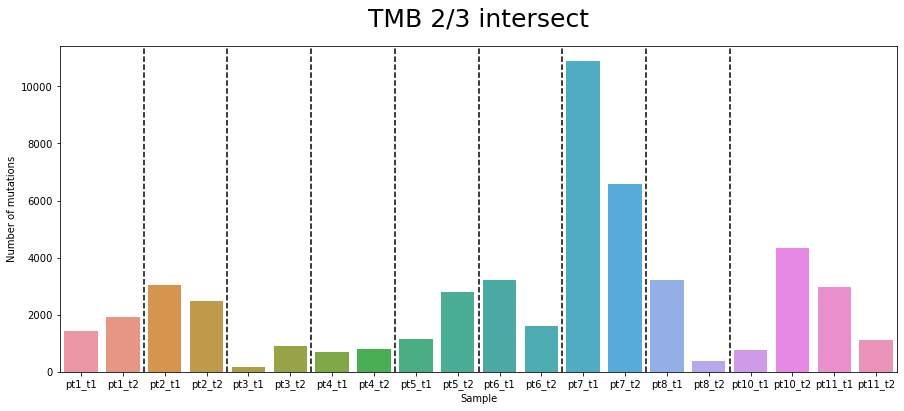

In [20]:
import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

tum_burden = []
for sample in samples_list:
    sample_name = retrieve_name(sample)[0].split('_df')[0]
    sample_final = []
    sample_final.append(sample_name)
    sample_final.append(len(sample[sample['gnomADg_AF']<0.001]))
    tum_burden.append(sample_final)
tum_burden_df = pd.DataFrame(tum_burden,columns=['Sample','Number of mutations'])
plt.figure(figsize=(15,6))
sns.barplot(tum_burden_df['Sample'],tum_burden_df['Number of mutations'])
plt.title('TMB 2/3 intersect',size=25,pad=20)
pos=1.5
while pos<16:
    plt.axvline(x=pos,color='k',linestyle='--')
    pos = pos + 2

In [24]:
target_df[['SAMPLE','DONOR']].groupby('SAMPLE',as_index=False).count()

NameError: name 'target_df' is not defined

In [24]:
stj_tb_df = stjude_df[['SAMPLE','CHROMOSOME']].groupby('SAMPLE',as_index=False).count()
stj_tb_df = stj_tb_df.rename(columns={'SAMPLE':'Sample','CHROMOSOME':'Number of mutations'})

In [25]:
hart_tb_df = hartwig_df[['SAMPLE','CHROMOSOME']].groupby('SAMPLE',as_index=False).count()
hart_tb_df = hart_tb_df.rename(columns={'SAMPLE':'Sample','CHROMOSOME':'Number of mutations'})

In [26]:
stj_tb_df['Dataset'] = 'St Jude'
hart_tb_df['Dataset'] = 'Hartwig'
tum_burden_df['Dataset'] = 'New samples'
tum_burden_df = pd.merge(tum_burden_df,stj_tb_df,how='outer')
tum_burden_df = pd.merge(tum_burden_df,hart_tb_df,how='outer')
tum_burden_df

Sample  Number of mutations      Dataset
0            pt1_t1                 1448  New samples
1            pt1_t2                 1939  New samples
2            pt2_t1                 3036  New samples
3            pt2_t2                 2471  New samples
4            pt3_t1                  188  New samples
...             ...                  ...          ...
4092  WIDE01010288T                 5633      Hartwig
4093  WIDE01010292T                 1346      Hartwig
4094  WIDE01010293T                  915      Hartwig
4095  WIDE01010305T               195178      Hartwig
4096  WIDE01010307T                36809      Hartwig

[4097 rows x 3 columns]

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'TMB comparison')

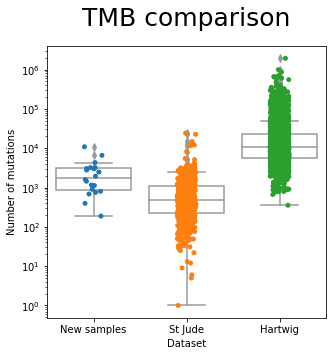

In [27]:
plt.figure(figsize=(5,5))
ax = sns.stripplot(tum_burden_df['Dataset'],tum_burden_df['Number of mutations'])
ax = sns.boxplot(tum_burden_df['Dataset'],tum_burden_df['Number of mutations'],color='white')
ax.set_yscale('log')
plt.title('TMB comparison',size=25,pad=20)

### Density plots

In [121]:
def density_plot (data,y_var,title,xlim,sample, bins=100,pos=2,vaf=False):
    '''Create density plot for CCF
    input: tumor data, title and xlim max
    output: plot()'''
    
    def slope(data_y,data_x,i):
        slope = (data_y[i+1] - data_y[i]) / (data_x[i+1] - data_x[i])
        return slope
    purity = data['purity'][0]
    data = data[(~data[y_var].isnull())&(data['t_CCF']<xlim)]
    data = data[y_var]
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 4)
    ax = sns.distplot(data,rug=True,bins=bins)
    ax.set_title(title,size=20,pad=20)
    ax.set_xlim(-0.5,xlim)
    if vaf==False:
        data_x, data_y = ax.lines[0].get_data()

        poss = []
        for i in range(len(data_y)):
            if i == 0 or i == (len(data_y)-1):
                pass
            else:
                if sample == 'pt1_t2':
                    if  slope(data_y,data_x,i)<0.8 and slope(data_y,data_x,i)>0.7:
                        pos = i
                        poss.append(pos)
                        
                elif sample == 'pt3_t2':
                    if  slope(data_y,data_x,i)<-0.8 and slope(data_y,data_x,i)>-0.9:
                        pos = i
                        poss.append(pos)
                
                elif sample == 'pt7_t1':
                    if  slope(data_y,data_x,i)<1.4382 and slope(data_y,data_x,i)>1:
                        pos = i
                        poss.append(pos)
                elif sample == 'pt7_t2':
                    if  slope(data_y,data_x,i)<1.5 and slope(data_y,data_x,i)>1.4:
                        pos = i
                        poss.append(pos)
                elif sample == 'pt10_t2':
                    if  slope(data_y,data_x,i)<0.1 and slope(data_y,data_x,i)>-0.1:
                        pos = i
                        poss.append(pos)
                else:
                    if (data_y[i] < data_y[i+1]) and (data_y[i] < data_y[i-1]):
                        poss.append(i)


        poss = [pos for pos in poss if data_x[pos] <1]
        if poss == []:
            pos = 0
        else:
            pos = max(poss)
        
        print(data_x[pos],data_y[pos])

        plt.axhline(y = data_y[pos],color='k',linewidth=1,linestyle='--')
        plt.axvline(x = data_x[pos],color='k',linewidth=1,linestyle='--')
        plt.text(data_x[pos]+0.1,data_y.max(),'Clonal')
        plt.text(2.5,data_y.max(),'Purity = '+str(purity))

In [122]:
def density_plot_poster (data,y_var,title,xlim1,xlim2,sample, bins=100,position=2,vaf=False):
    '''Create density plot for CCF
    input: tumor data, title and xlim max
    output: plot()'''
    
    def slope(data_y,data_x,i):
        slope = (data_y[i+1] - data_y[i]) / (data_x[i+1] - data_x[i])
        return slope
    purity = data['purity'][0]    
    data = data[(~data[y_var].isnull())&(data['t_CCF']<xlim2)]
    data = data[y_var]
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 2)
    ax = sns.distplot(data,rug=True,bins=bins)
    ax.set_title(title,size=20,pad=10)
    ax.set_xlim(xlim1,xlim2)
    plt.ylabel('Density', fontsize=16)
    plt.xlabel('CCF', fontsize=16)
    if vaf==False:
        data_x, data_y = ax.lines[0].get_data()

        poss = []
        for i in range(len(data_y)):
            if i == 0 or i == (len(data_y)-1):
                pass
            else:
                if sample == 'pt1_t2':
                    if  slope(data_y,data_x,i)<0.8 and slope(data_y,data_x,i)>0.7:
                        pos = i
                        poss.append(pos)
                elif sample == 'pt3_t2':
                    if  slope(data_y,data_x,i)<-0.8 and slope(data_y,data_x,i)>-0.9:
                        pos = i
                        poss.append(pos)
                elif sample == 'pt4_t1':
                    if  slope(data_y,data_x,i)<-0.2 and slope(data_y,data_x,i)>-0.25:
                        pos = i
                        poss.append(pos)
                elif sample == 'pt7_t1':
                    if  slope(data_y,data_x,i)<1.4382 and slope(data_y,data_x,i)>1:
                        pos = i
                        poss.append(pos)
                elif sample == 'pt7_t2':
                    if  slope(data_y,data_x,i)<1.5 and slope(data_y,data_x,i)>1.4:
                        pos = i
                        poss.append(pos)
                elif sample == 'pt10_t2':
                    if  slope(data_y,data_x,i)<0.1 and slope(data_y,data_x,i)>-0.1:
                        pos = i
                        poss.append(pos)
                else:
                    if (data_y[i] < data_y[i+1]) and (data_y[i] < data_y[i-1]):
                        poss.append(i)
                        print(data_y[i],i)

        poss = [pos for pos in poss if data_x[pos] <1]
        if poss == []:
            pos = 0
        else:
            pos = max(poss)
        
        print(data_x[pos],data_y[pos])

        #plt.axhline(y = data_y[pos],color='k',linewidth=1.5,linestyle='--')
        plt.axvline(x = data_x[pos],color='k',linewidth=1.5,linestyle='--')
        #plt.text(data_x[pos]+0.1,data_y.max(),'Clonal',size=16)
        plt.text(xlim2*0.7,data_y.max(),'Clonal',size=16)
        plt.text(xlim2*0.7,data_y.max()*0.7,'Purity = '+str(purity))

In [123]:
def get_ccf_threshold (data,sample,title):
    '''get threshold for clonal fraction of the variants
    input: data table per sample
    output: float, t_CCF value'''
    purity = data['purity'][0]
    def slope(data_y,data_x,i):
        slope = (data_y[i+1] - data_y[i]) / (data_x[i+1] - data_x[i])
        return slope
    y_var='t_CCF'
    xlim=3
    data = data[(~data[y_var].isnull())&(data['t_CCF']<xlim)]
    data = data[y_var]
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 2)
    ax = sns.distplot(data,rug=True,bins=50)
    data_x, data_y = ax.lines[0].get_data()

    poss = []
    for i in range(len(data_y)):
        if i == 0 or i == (len(data_y)-1):
            pass
        else:
            if sample == 'pt1_t2':
                if  slope(data_y,data_x,i)<0.8 and slope(data_y,data_x,i)>0.7:
                    pos = i
                    poss.append(pos)
            elif sample == 'pt3_t2':
                if  slope(data_y,data_x,i)<-0.8 and slope(data_y,data_x,i)>-0.9:
                    pos = i
                    poss.append(pos)
            elif sample == 'pt4_t1':
                if  slope(data_y,data_x,i)<-0.2 and slope(data_y,data_x,i)>-0.25:
                    pos = i
                    poss.append(pos)
            elif sample == 'pt7_t1':
                print(data_x[0])
                pos = 50
                poss.append(pos)
            elif sample == 'pt7_t2':
                if  slope(data_y,data_x,i)<1.5 and slope(data_y,data_x,i)>1.4:
                    pos = i
                    poss.append(pos)
            elif sample == 'pt10_t2':
                if  slope(data_y,data_x,i)<0.1 and slope(data_y,data_x,i)>-0.1:
                    pos = i
                    poss.append(pos)
            else:
                if (data_y[i] < data_y[i+1]) and (data_y[i] < data_y[i-1]):
                    poss.append(i)
#                     print(data_y[i],i)
    poss = [pos for pos in poss if data_x[pos] <1]
    if poss == []:
        pos = 0
    else:
        pos = max(poss)
        
    plt.axhline(y = data_y[pos],color='k',linewidth=1,linestyle='--')
    plt.axvline(x = data_x[pos],color='k',linewidth=1,linestyle='--')
    plt.text(data_x[pos]+0.1,data_y.max(),'Clonal',size=14)
    plt.text(data_x.max()*0.7,data_y.max(),'Purity = '+str(purity))
    ax.set_title(title,size=20,pad=20)

    return data_x[pos]

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.0470683

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


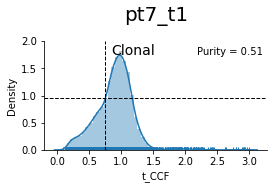

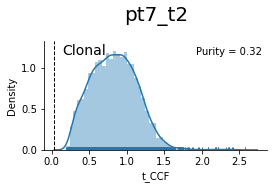

In [124]:
pt = 'pt7'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
data = final_dataframe(pt,tumor,normal,'intersect','t1')
sample = pt + '_t1'
threshold = get_ccf_threshold(data,sample,sample)
tumor = samples[pt]['tumor2']
data = final_dataframe(pt,tumor,normal,'intersect','t2')
sample = pt + '_t2'
threshold = get_ccf_threshold(data,sample,sample)

In [125]:
pts = ['pt1','pt2','pt3','pt4','pt5','pt6','pt7','pt8','pt10','pt11']

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.047068366228769754
-0.0470683

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


{'pt1_t1': 0.4795411737486141,
 'pt1_t2': 0.5113676352736383,
 'pt2_t1': 0.6057787222048805,
 'pt2_t2': 0.5363311165234896,
 'pt3_t1': 0.4880408661925021,
 'pt3_t2': 0.6594260071476463,
 'pt4_t1': 0.5975810100538136,
 'pt4_t2': -0.14397187215406504,
 'pt5_t1': 0.585422218524073,
 'pt5_t2': 0.7632801444526164,
 'pt6_t1': 0.5519022116881267,
 'pt6_t2': 0.5573365597891763,
 'pt7_t1': 0.7493648230279774,
 'pt7_t2': 0.03738869955168944,
 'pt8_t1': 0.49050357099165653,
 'pt8_t2': 0.4758741534200194,
 'pt10_t1': 0.4772196577906531,
 'pt10_t2': 0.5840021457667295,
 'pt11_t1': 0.5041270825578086,
 'pt11_t2': 0.905108249088037}

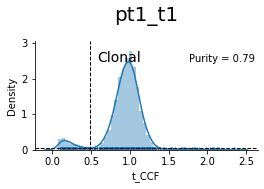

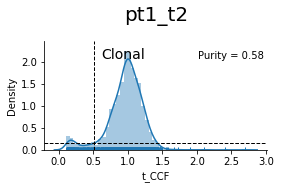

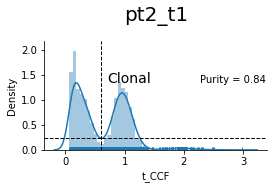

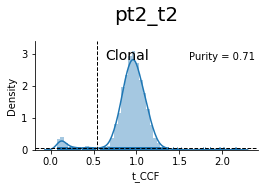

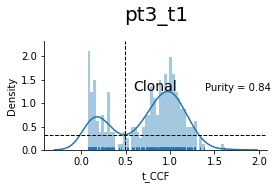

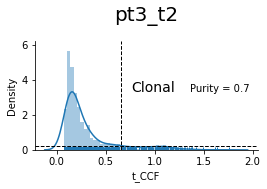

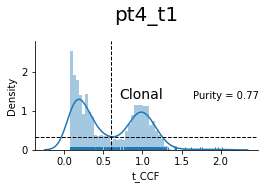

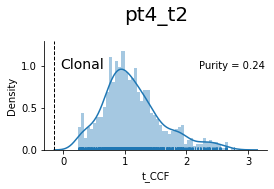

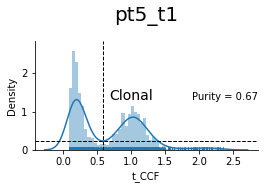

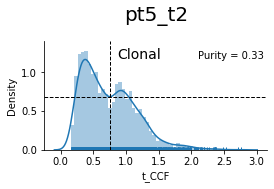

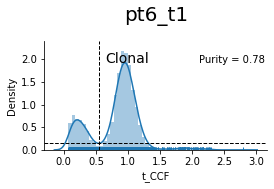

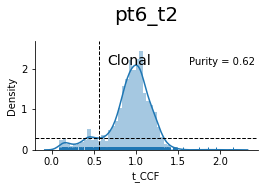

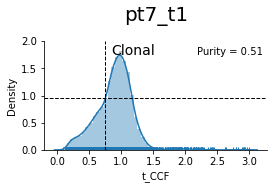

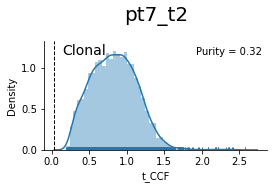

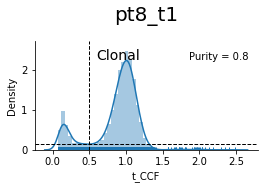

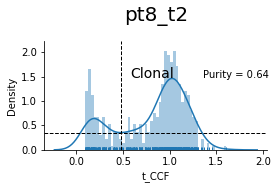

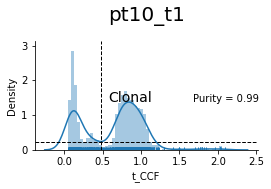

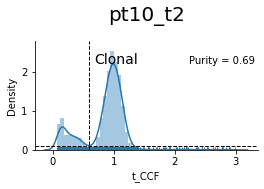

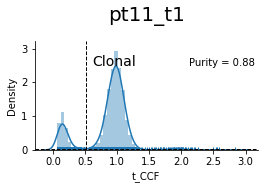

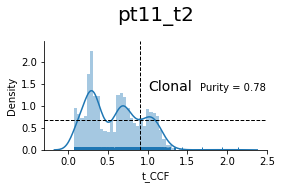

In [126]:
thresholds = {}
for pt in tqdm(pts):
    tumor = samples[pt]['tumor1']
    normal = samples[pt]['normal']
    data = final_dataframe(pt,tumor,normal,'intersect','t1')
    sample = pt + '_t1'
    threshold = get_ccf_threshold(data,sample,sample)
    thresholds[sample] = threshold
    tumor = samples[pt]['tumor2']
    data = final_dataframe(pt,tumor,normal,'intersect','t2')
    sample = pt + '_t2'
    threshold = get_ccf_threshold(data,sample,sample)
    thresholds[sample] = threshold
thresholds

In [127]:
thresholds

{'pt1_t1': 0.4795411737486141,
 'pt1_t2': 0.5113676352736383,
 'pt2_t1': 0.6057787222048805,
 'pt2_t2': 0.5363311165234896,
 'pt3_t1': 0.4880408661925021,
 'pt3_t2': 0.6594260071476463,
 'pt4_t1': 0.5975810100538136,
 'pt4_t2': -0.14397187215406504,
 'pt5_t1': 0.585422218524073,
 'pt5_t2': 0.7632801444526164,
 'pt6_t1': 0.5519022116881267,
 'pt6_t2': 0.5573365597891763,
 'pt7_t1': 0.7493648230279774,
 'pt7_t2': 0.03738869955168944,
 'pt8_t1': 0.49050357099165653,
 'pt8_t2': 0.4758741534200194,
 'pt10_t1': 0.4772196577906531,
 'pt10_t2': 0.5840021457667295,
 'pt11_t1': 0.5041270825578086,
 'pt11_t2': 0.905108249088037}

In [29]:
thresholds

{'pt1_t1': 0.8682485982482773,
 'pt1_t2': 0.5146613817622611,
 'pt2_t1': 0.6150859251839021,
 'pt2_t2': 0.9033595790612529,
 'pt3_t1': 0.4812578196106907,
 'pt3_t2': 0.6473980330683812,
 'pt4_t1': 0.9875782774884736,
 'pt4_t2': -0.1108650690841414,
 'pt5_t1': 0.5763852035588022,
 'pt5_t2': 0.7351190698025113,
 'pt6_t1': 0.555762660197982,
 'pt6_t2': 0.5577318045536523,
 'pt7_t1': 0.7470228505723339,
 'pt7_t2': 0.037595708297121694,
 'pt8_t1': 0.5056422380250599,
 'pt8_t2': 0.7771632235420951,
 'pt10_t1': 0.47149743205917605,
 'pt10_t2': 0.985619850437473,
 'pt11_t1': 0.4864788949265142,
 'pt11_t2': 0.9009491373952956}

In [128]:
json.dump(thresholds, open( "/workspace/projects/sjd_pediatric_tumors/code/ccf_thresholds2.json", "w" ) )

In [72]:
sample

#CHROM        POS ID     REF ALT  QUAL FILTER  \
0      chr1    3985668  .       A   -   656   PASS   
1      chr1    8139423  .       G   T   825   PASS   
2      chr1   11266002  .       T   -   247   PASS   
3      chr1   19841394  .       C   T  1048   PASS   
4      chr1   22354916  .       C   A     .   PASS   
...     ...        ... ..     ...  ..   ...    ...   
1913   chrX  150142831  .       T   -   585   PASS   
1914   chrX  152047311  .       T   -   497   PASS   
1915   chrX  152460903  .  AAATAT   -   433   PASS   
1916   chrX  152495998  .       C   A  1007   PASS   
1917   chrX  152496572  .       T   -     .   PASS   

                                                   INFO  \
0     MH=A;RC=TACAAAAAAAAAAAAAAAAAGC;RC_IDX=2;RC_LF=...   
1     LPS=1;LPS_RC=27;RC=TATCC;RC_IDX=2;RC_LF=ATACAA...   
2     MH=T;RC=TCCTTTTTTTTTTTTTTTTTTTTTTGA;RC_IDX=2;R...   
3     RC=GGTCA;RC_IDX=2;RC_LF=AGACCAGCCT;RC_NM=1;RC_...   
4     DP=174;MQ=59.90;MQ0=0;NT=ref;QSS=80;QSS_NT=80;...   
...                                                 ...   
1913  MH=T;RC=AGGTTTTTTTTTTTTTCT;RC_IDX=2;RC_LF=CAGT...   
1914  MH=T;RC=GCCTTTTTTTTTTTTTTGG;RC_IDX=2;RC_LF=AAG...   
1915  MH=A;RC=CAAAAAAAAAAAAATAT;RC_IDX=12;RC_LF=GAAT...   
1916  RC=GAAAAG;RC_IDX=3;RC_LF=ACTACCACGA;RC_NM=1;RC...   
1917  IC=9;IHP=10;MQ=60.00;MQ0=0;NT=ref;QSI=122;QSI_...   

                                                 FORMAT  \
0     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
2     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
3     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
4                          DP:FDP:SDP:SUBDP:AU:CU:GU:TU   
...                                                 ...   
1913  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1914  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1915  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1916  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1917        DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50   

                                                 NORMAL  ... gnomADg_AF  \
0     ./.:99,0:0:111:3592,0:116,0:0,0,0,0,0,99,111:0...  ...   0.346909   
1     ./.:117,0:0:117:4428,0:122,0:0,0,0,0,0,117,117...  ...   0.000000   
2     ./.:88,0:0:91:3066,0:106,0:0,0,0,0,0,88,91:0:0...  ...   0.018384   
3     ./.:110,0:0:110:4120,0:112,0:0,0,0,0,0,110,110...  ...   0.000007   
4                         117:3:0:0:0,0:113,116:1,1:0,0  ...   0.000007   
...                                                 ...  ...        ...   
1913  ./.:99,0:0:102:3509,0:105,0:0,0,0,0,0,99,102:0...  ...   0.029149   
1914  ./.:98,0:0:105:3637,0:117,0:0,0,0,0,0,98,105:0...  ...   0.017334   
1915  ./.:85,0:0:85:3256,0:90,0:0,0,0,0,0,85,85:0:0,...  ...   0.166475   
1916  ./.:132,0:0:132:5144,0:140,0:0,0,0,0,0,132,132...  ...   0.000000   
1917    145:145:131,133:3,3:11,11:138.47:1.09:0.00:0.01  ...   0.007984   

      gnomADg_NFE    subset_origin            SAMPLE  nMinor  nMajor   CN  \
0               -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     0.0  2.0   
1               -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     0.0  2.0   
2               -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     0.0  2.0   
3               -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     0.0  2.0   
4               -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     0.0  2.0   
...           ...              ...               ...     ...     ...  ...   
1913            -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     2.0  4.0   
1914            -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     2.0  4.0   
1915            -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     2.0  4.0   
1916            -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     2.0  4.0   
1917            -  tumor_vs_normal  AQ5180_vs_AQ5174     2.0     2.0  4.0   

         t_CCF     n_CCF purity  
0     1.688608  0.000000   0.79  
1     1.637975  0.000000   0.79  
2     0.86

In [75]:
retrieve_name(sample)[1].split('_df')[0]

'pt1_t1'

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


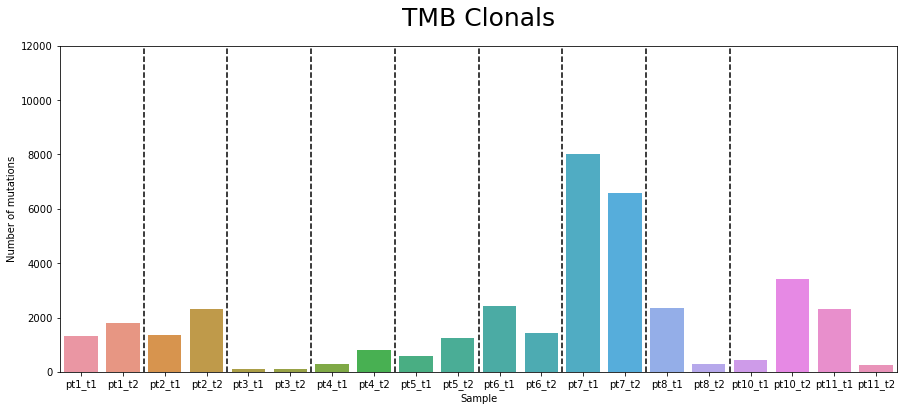

In [81]:
import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

tum_burden = []
for sample in samples_list:
    sample_name = retrieve_name(sample)[0].split('_df')[0]
    sample_final = []
    sample_final.append(sample_name)
    ccf_threshold = thresholds[sample_name]
    sample_final.append(len(sample[(sample['gnomADg_AF']<0.001)&(sample['t_CCF']>ccf_threshold)]))
    tum_burden.append(sample_final)
tum_burden_df = pd.DataFrame(tum_burden,columns=['Sample','Number of mutations'])
plt.figure(figsize=(15,6))
sns.barplot(tum_burden_df['Sample'],tum_burden_df['Number of mutations'])
plt.title('TMB Clonals',size=25,pad=20)
plt.ylim(0,12000)
pos=1.5
while pos<16:
    plt.axvline(x=pos,color='k',linestyle='--')
    pos = pos + 2

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


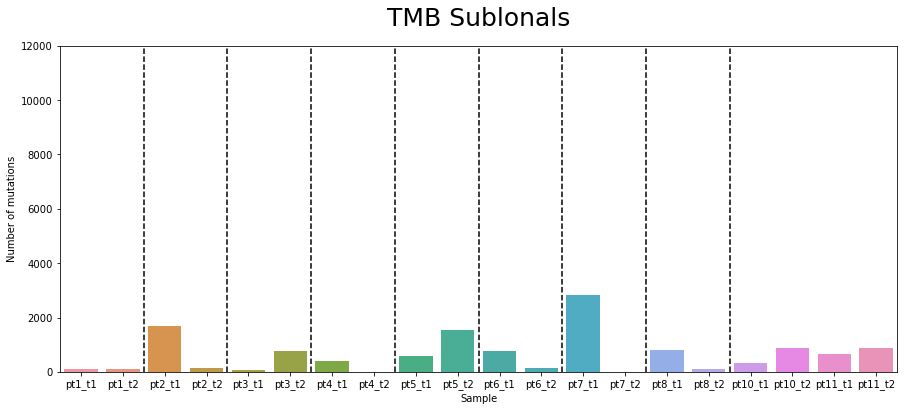

In [83]:
import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

tum_burden = []
for sample in samples_list:
    sample_name = retrieve_name(sample)[0].split('_df')[0]
    sample_final = []
    sample_final.append(sample_name)
    ccf_threshold = thresholds[sample_name]
    sample_final.append(len(sample[(sample['gnomADg_AF']<0.001)&(sample['t_CCF']<ccf_threshold)]))
    tum_burden.append(sample_final)
tum_burden_df = pd.DataFrame(tum_burden,columns=['Sample','Number of mutations'])
plt.figure(figsize=(15,6))
sns.barplot(tum_burden_df['Sample'],tum_burden_df['Number of mutations'])
plt.title('TMB Sublonals',size=25,pad=20)
plt.ylim(0,12000)
pos=1.5
while pos<16:
    plt.axvline(x=pos,color='k',linestyle='--')
    pos = pos + 2

### Mutect

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

0.850418333856265 0.08973099321363233
0.5420936453628568 0.25312237789662556
0.6327707473621456 0.229775299644833
0.9457454978342172 0.08823541589447521


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.6125306048773418 0.34209254276652656
0.7156028481516863 0.15544329006631322
-0.4055671113103678 0.0020081615649838675
0.6192840128639625 0.5460721229226303


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.6142550299979298 0.3131220371987731
0.7368650821752356 0.6598330379779219
0.5593024907689235 0.1937677343094138


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.550710567002799 0.32234047621127093
0.9449965764176181 1.6729250350277556


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.2924950542631614 0.41289002357600285
0.5339510128508994 0.14258841741349887
-0.46373284369273887 0.001125459760312946


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.5099689402081636 0.3568534887677777
-0.18770644442722578 0.0025043737701287835
0.5862343309675081 0.11847061675795875


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


0.899413023235999 0.3277056972907


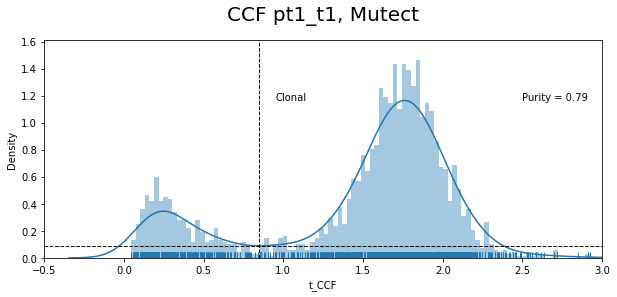

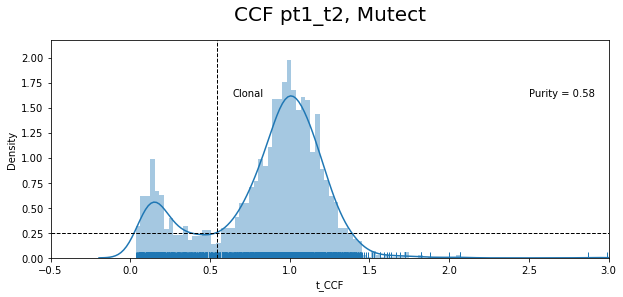

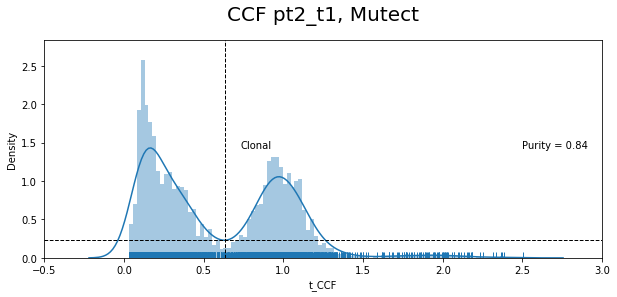

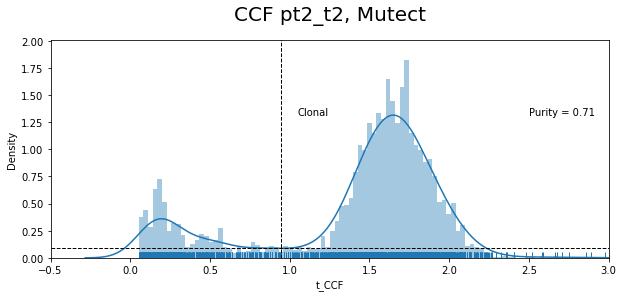

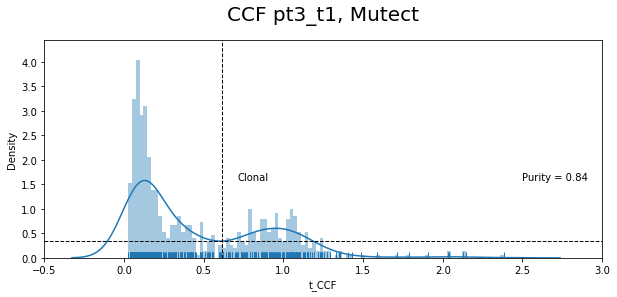

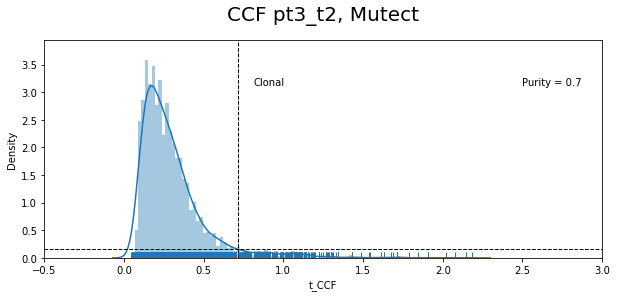

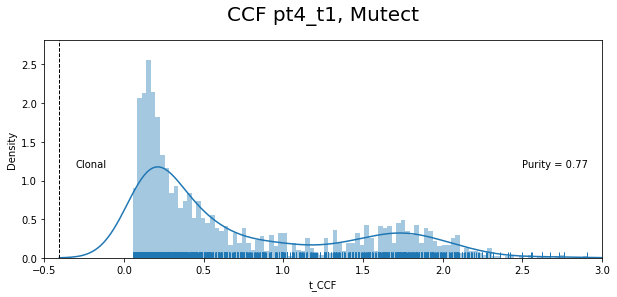

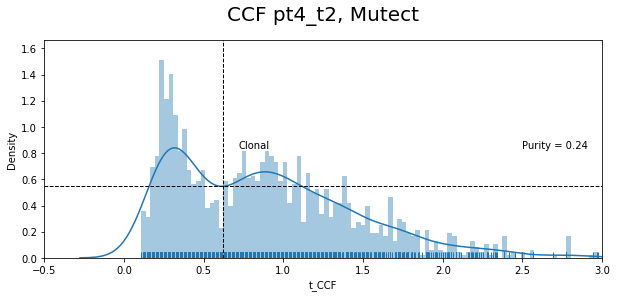

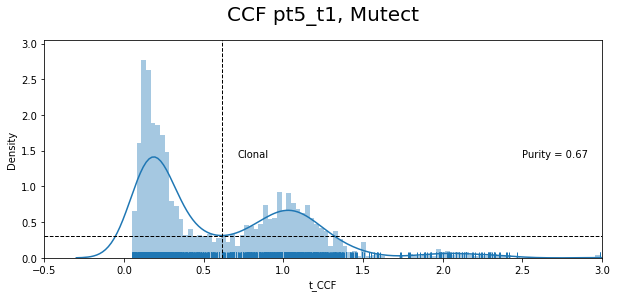

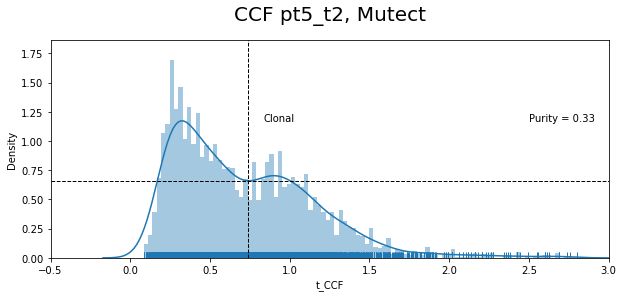

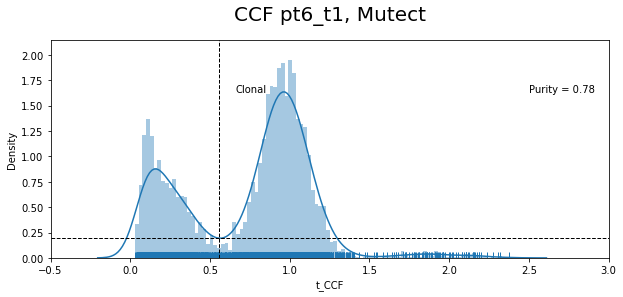

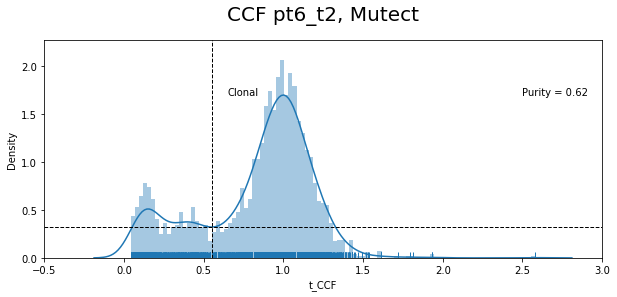

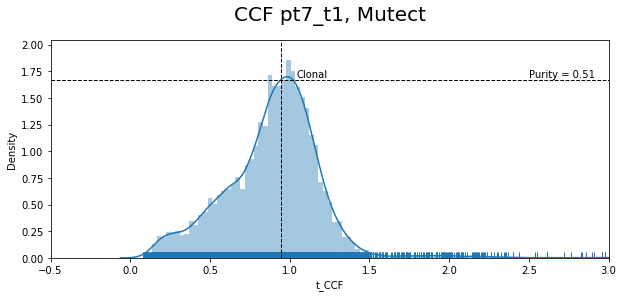

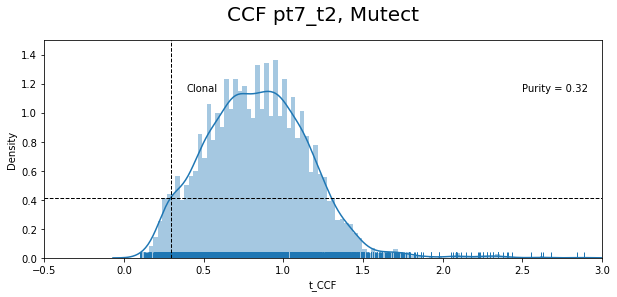

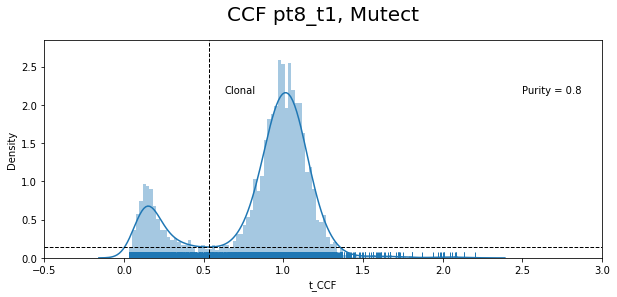

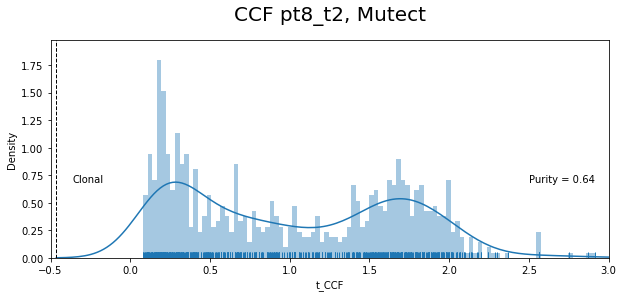

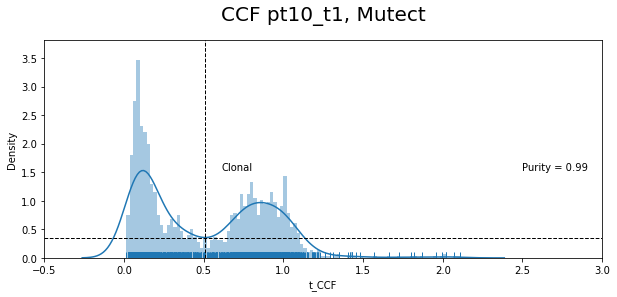

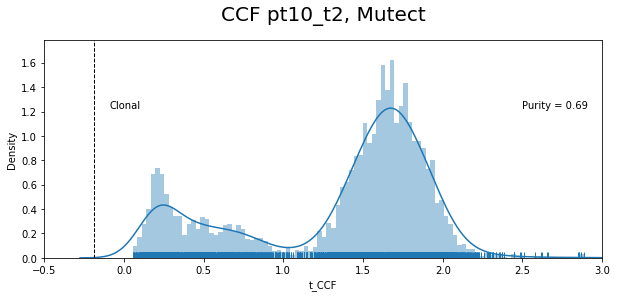

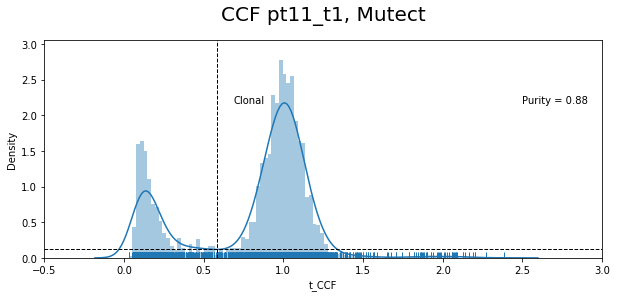

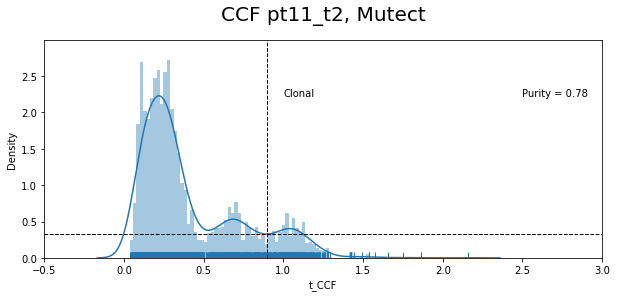

In [37]:
j = 0
for pt in pts:
    for tumor in ['_t1','_t2']:
        sample_id = pt + tumor
        title = 'CCF '+sample_id+', Mutect'
        sample_df = samples_mutect_list[j]
        data = sample_df.copy(deep=False)
        density_plot(data,'t_CCF',title,3,pos=2.2,sample=sample_id)
        j = j +1


### Strelka

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

0.8624673843946598 0.04478245200753411
0.6063572584353077 0.09690710878382318
0.6380852518168474 0.15658750061463592


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.8082239001846803 0.04948941974071604
0.6171111818971504 0.07496298638145453
0.7283077561904695 0.13594287857733306


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

-0.1542938012348416 0.0069801294661958075
0.5890715976811197 0.10556492249008445
0.6065647788778292 0.1499076819921627


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.7437793174605336 0.4465946312840963
0.5601154404997484 0.10530406022396542


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.5412137802611601 0.12719072203199724
0.9332393937843749 1.5191774379498897


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

-0.08462329055436763 5.068285374845495e-05
0.5171788271149067 0.17619822285944178
0.9421396710352695 0.1439126953100711


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.49234619818248915 0.22088524740252918
0.9915320165265573 0.0649950439857718


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


0.5335465809624135 0.02995166895127771
0.9052881412473278 0.3224006618176615


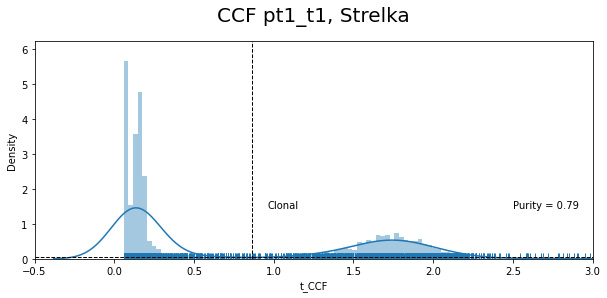

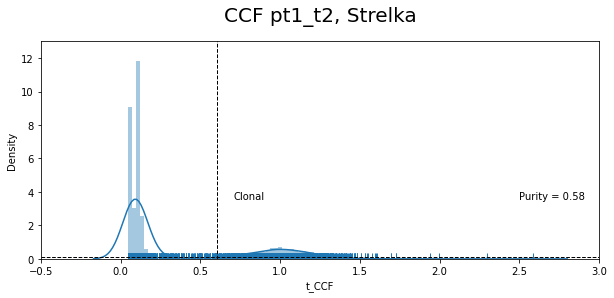

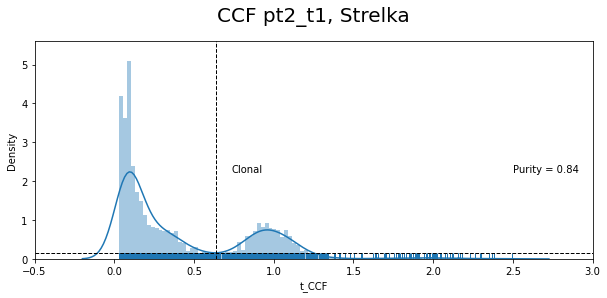

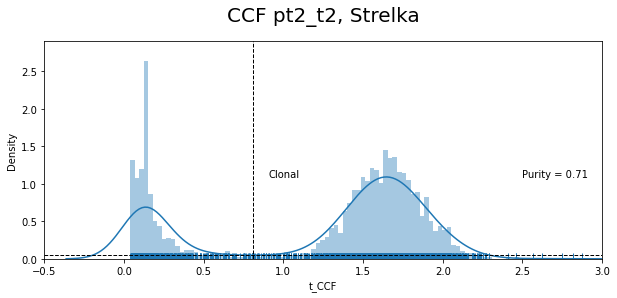

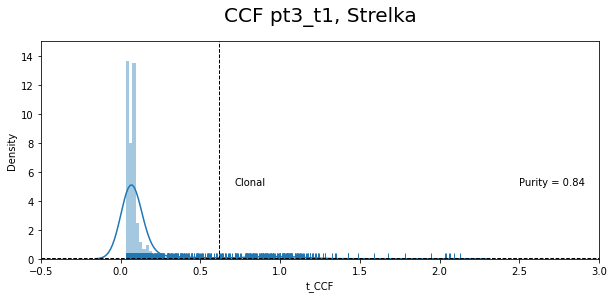

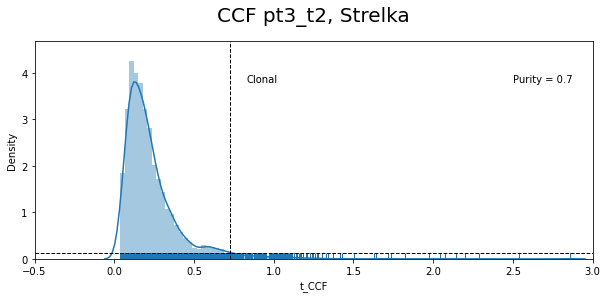

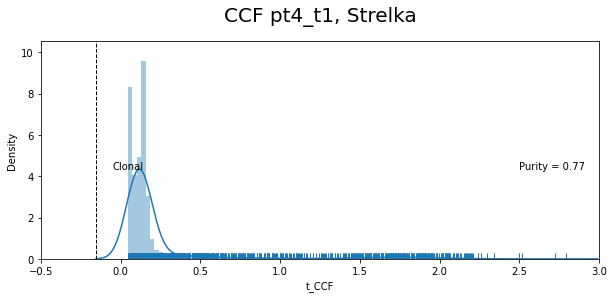

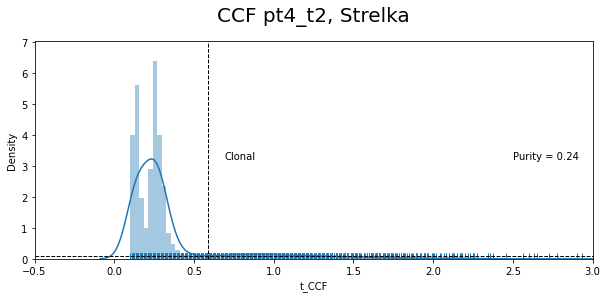

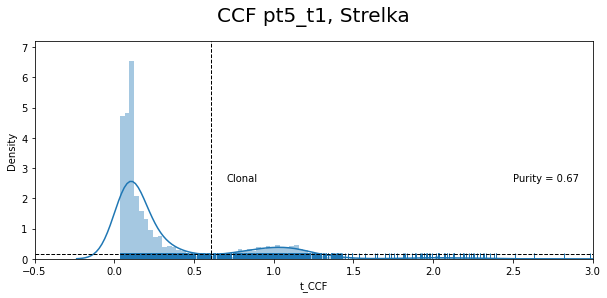

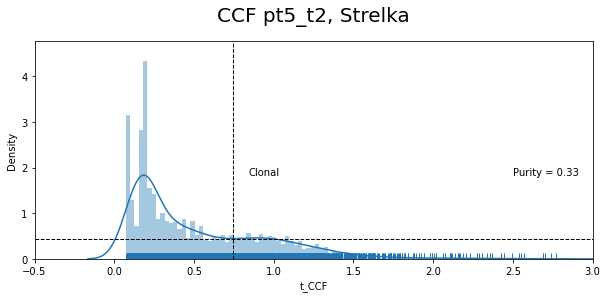

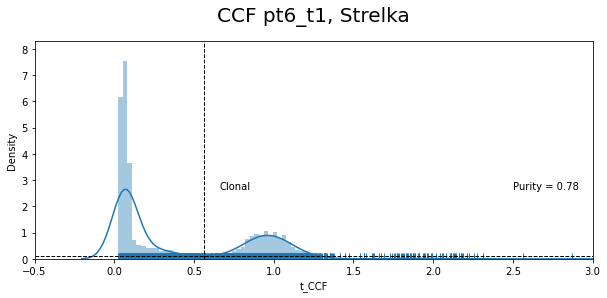

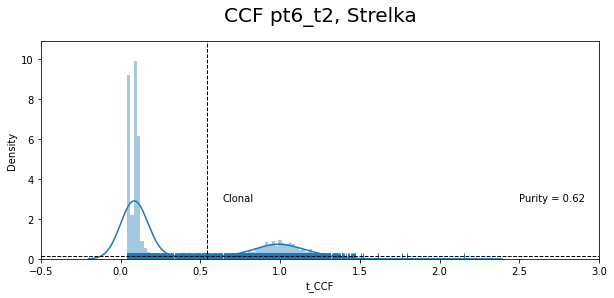

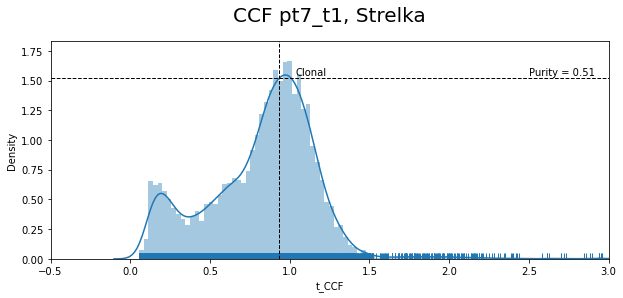

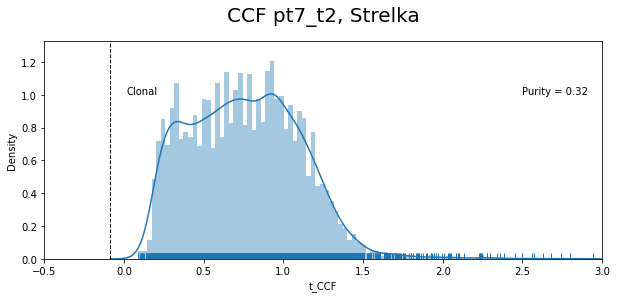

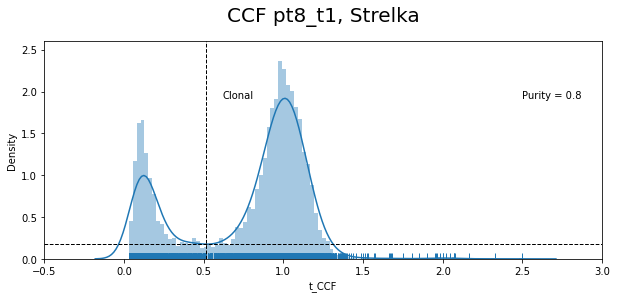

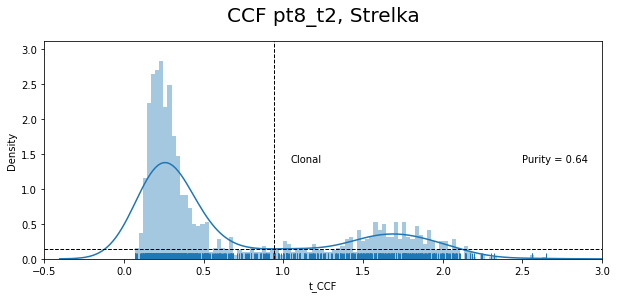

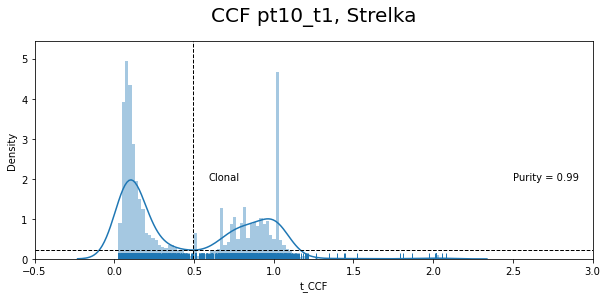

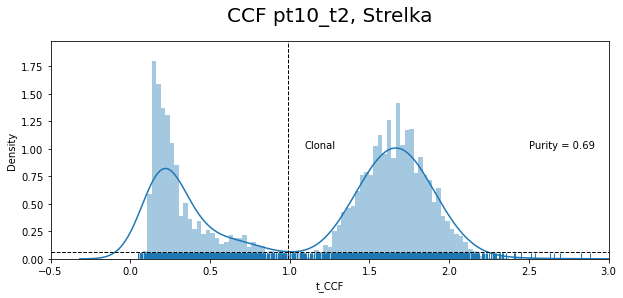

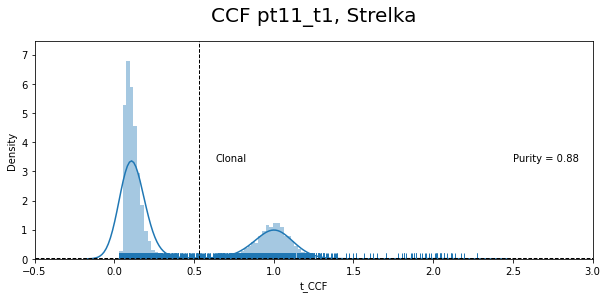

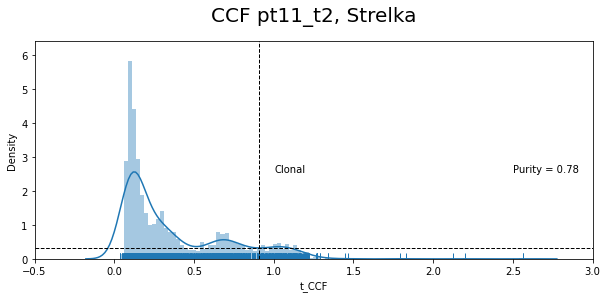

In [38]:
j = 0
for pt in pts:
    for tumor in ['_t1','_t2']:
        sample_id = pt + tumor
        title = 'CCF '+sample_id+', Strelka'
        sample_df = samples_strelka_list[j]
        data = sample_df.copy(deep=False)
        density_plot(data,'t_CCF',title,3,pos=2.2,sample=sample_id)
        j = j +1


### 2/3 Intersect

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

0.8682485982482775 0.029282567887728966
0.5146613817622611 0.15170034698307563
0.615085925183902 0.21619181615237976
0.9033595790612529 0.02652319786878952
0.4812578196106907 0.3619792878208052
0.6473980330683812 0.2606421186915682
-0.4268963621769457 0.0018755313760945862
-0.11086506908414134 0.00044562036129897834


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.5763852035588022 0.2348835445446857
0.7351190698025112 0.7130071535665456
0.5557626601979819 0.13720119932551958
0.5577318045536523 0.2845344107505632


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.44529702058801673 0.3776689554128073
0.03759570829712164 5.855395494882223e-05
0.5056422380250599 0.1390189492821461
0.777163223542095 0.20970330946232982


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.47149743205917605 0.23527343802775644
0.985619850437473 0.06154288991815011
0.4864788949265141 0.030345644799083867
0.9009491373952955 0.6866476541468934


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


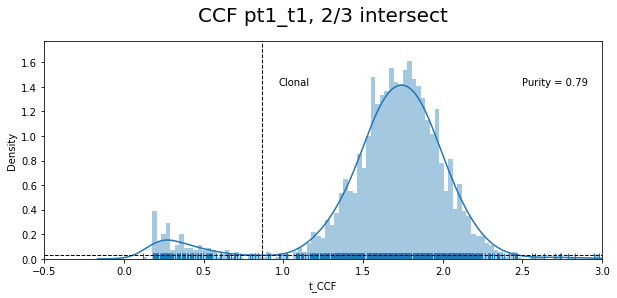

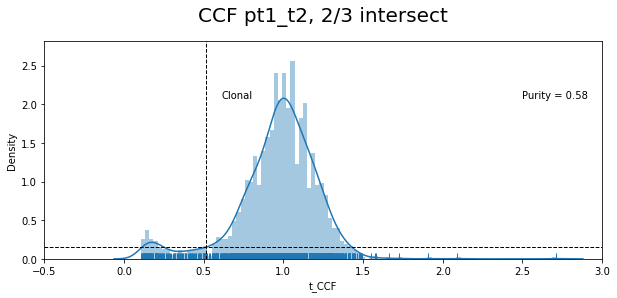

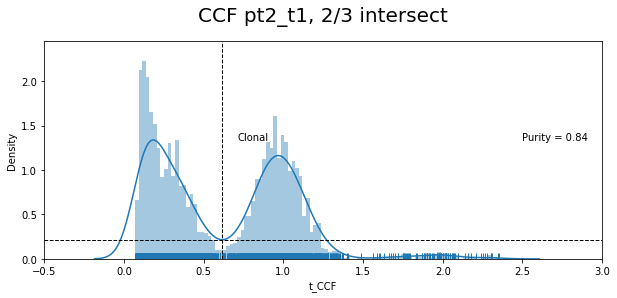

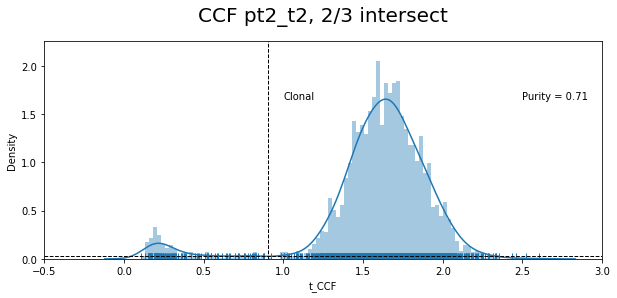

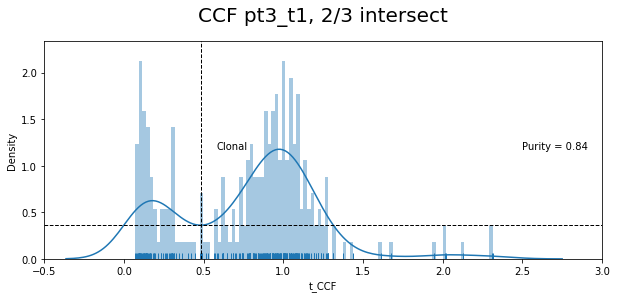

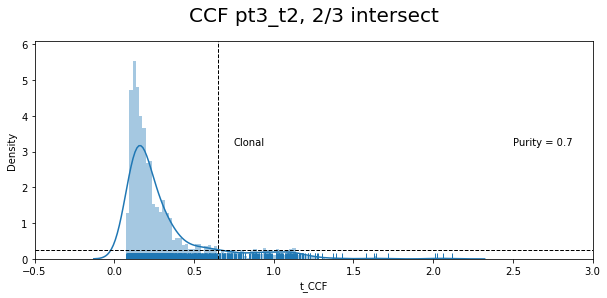

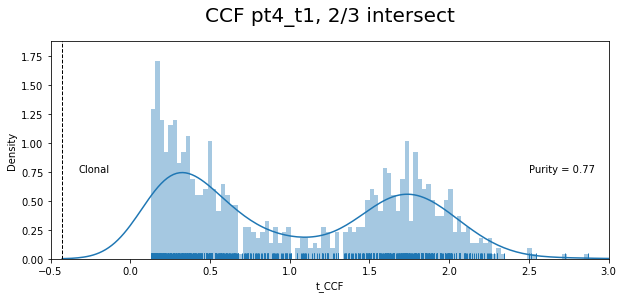

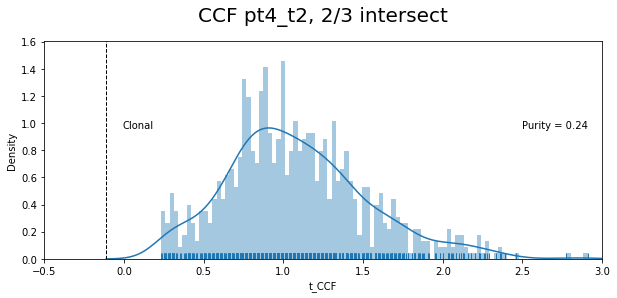

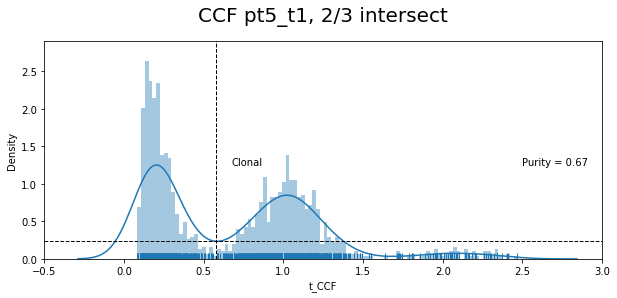

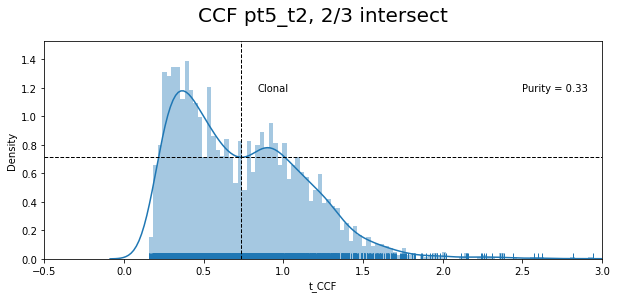

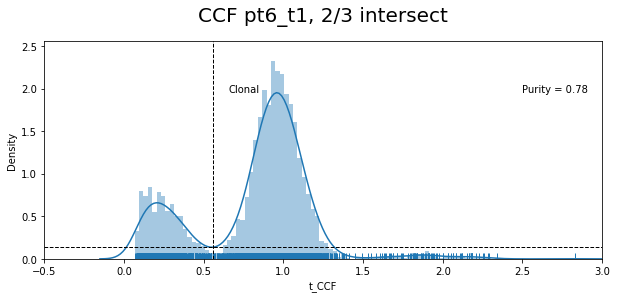

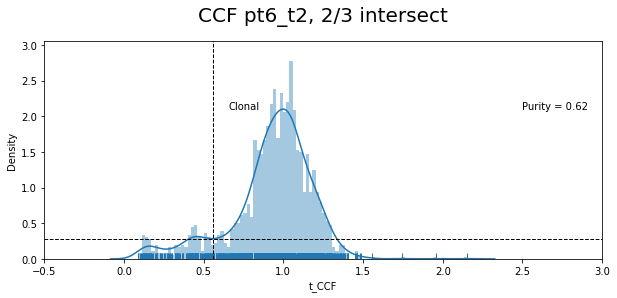

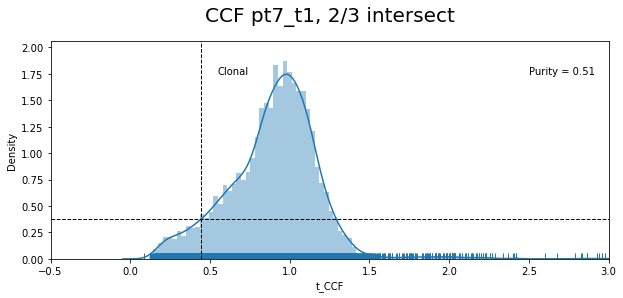

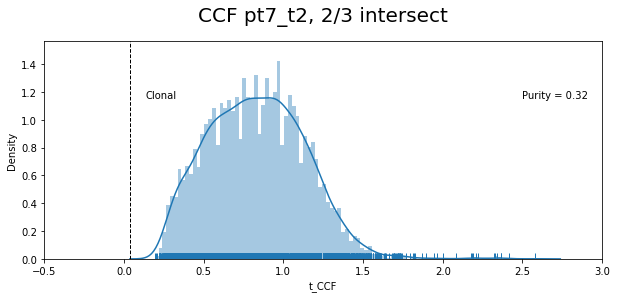

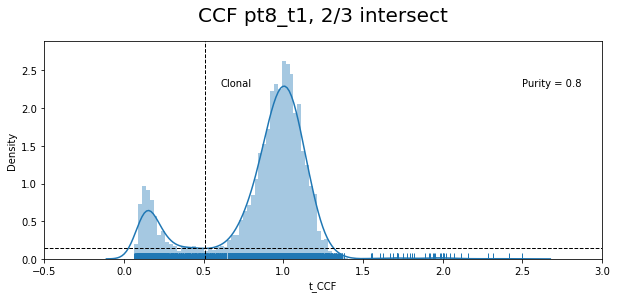

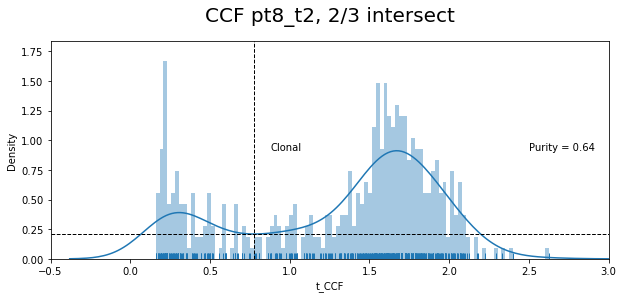

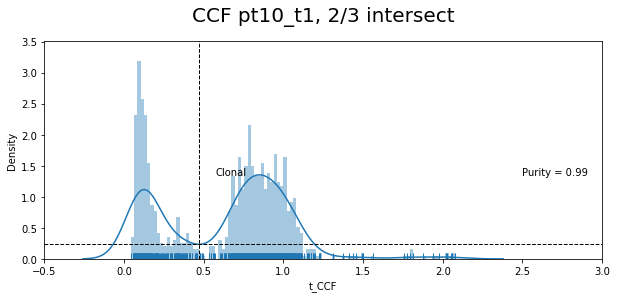

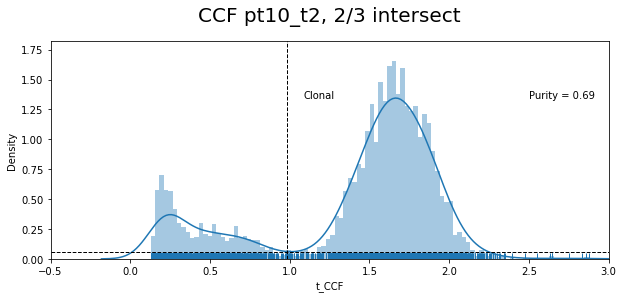

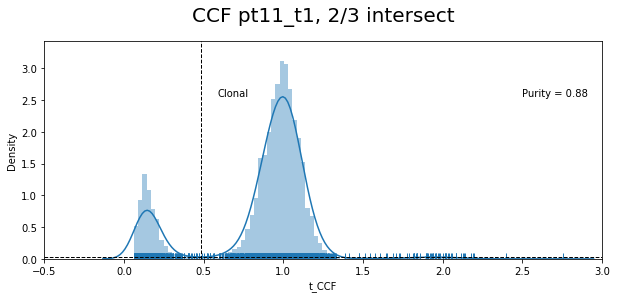

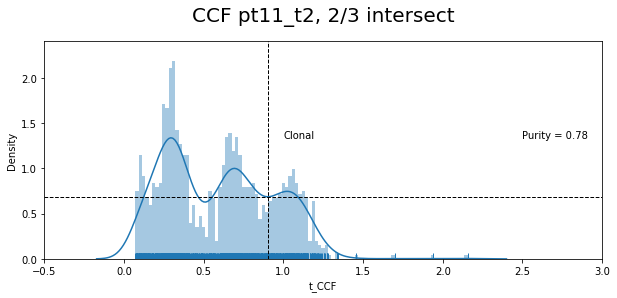

In [39]:
j = 0
for pt in pts:
    for tumor in ['_t1','_t2']:
        sample_id = pt + tumor
        title = 'CCF '+sample_id+', 2/3 intersect'
        sample_df = samples_list[j]
        data = sample_df.copy(deep=False)
        density_plot(data,'t_CCF',title,3,pos=2.2,sample=sample_id)
        j = j +1


### Plots for Poster

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

0.029282567887728966 60
0.8682485982482773 0.029282567887728966
0.5204088959764092 0.15535237598685211


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.20889200125990445 65
0.010125276850542604 141
0.6122945484408496 0.20889200125990445
0.02903031600255966 52
0.026523197868789514 69
0.9033595790612529 0.026523197868789514


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.3449452129697588 60
0.48099023068469937 0.3449452129697588


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


0.6652816451194807 0.2466442935025581


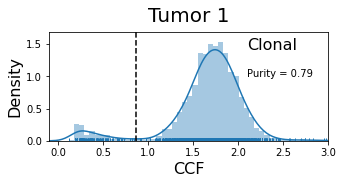

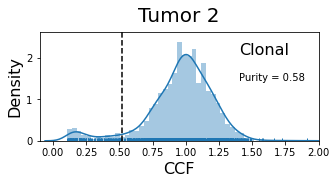

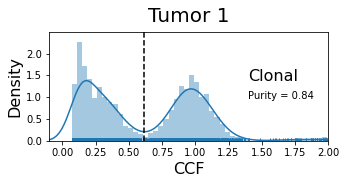

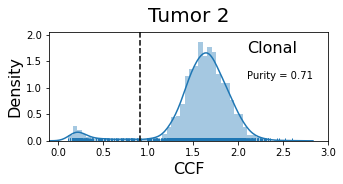

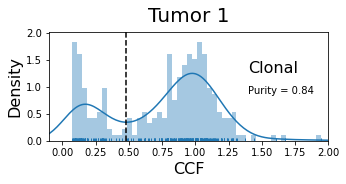

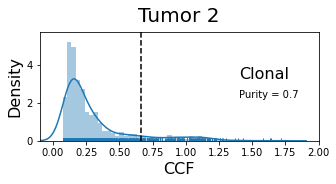

In [34]:
j = 0
for pt in ['pt1','pt2','pt3']:
    for tumor in ['_t1','_t2']:
        if tumor == '_t1':
            title = 'Tumor 1'
        else:
            title = 'Tumor 2'
        sample_id = pt + tumor
        sample_df = samples_list[j]
        data = sample_df.copy(deep=False)
        if (pt == 'pt1' and tumor == '_t1') or (pt == 'pt2' and tumor == '_t2'):
            xlim2 = 3
        else:
            xlim2 = 2
        density_plot_poster(data,'t_CCF',title,xlim1=-0.1,xlim2=xlim2,bins=50, position=1.2,sample=sample_id)
        j = j +1


In [51]:
pts

['pt1', 'pt2', 'pt3', 'pt4', 'pt5', 'pt6', 'pt7', 'pt8', 'pt10', 'pt11']

In [37]:
#NB
df = samples_list[0] 
print(df['t_CCF'].mean())
#MRT
df = samples_list[1]
print(df['t_CCF'].mean())
#RMS
df = samples_list[2]
print(df['t_CCF'].mean())
#AML
df = samples_list[3]
print(df['t_CCF'].mean())
df = samples_list[4]
#EPN
print(df['t_CCF'].mean())
#DMG
df = samples_list[5]
print(df['t_CCF'].mean())

1.663346952023263
0.9597227032592369
0.6294147434024735
1.5854695054279833
0.7748488284202569
0.31341252919078083


In [31]:
samples_list[2]

#CHROM        POS ID REF ALT  QUAL FILTER  \
0      chr1    1466243  .   A   -   478   PASS   
1      chr1    2124674  .   G   A  1387   PASS   
2      chr1    3812176  .   T   C   285   PASS   
3      chr1    4835029  .   -  TA   540   PASS   
4      chr1    6993922  .   G   T   501   PASS   
...     ...        ... ..  ..  ..   ...    ...   
3431   chrX  154055067  .   T   C  1150   PASS   
3432   chrX  154408657  .   A   C     .   PASS   
3433   chrX  155126282  .   T   A  1121   PASS   
3434   chrX  155724159  .   C   G   499   PASS   
3435   chrY   11456406  .   A   G     .   PASS   

                                                   INFO  \
0     MH=A;RC=CTCAAAAAAAAAAAAAAAAAAAAATG;RC_IDX=2;RC...   
1     LPS=1;LPS_RC=55;RC=ACAGG;RC_IDX=2;RC_LF=GGCTGA...   
2     RC=ATTTCGT;RC_IDX=4;RC_LF=TTACTTAGAT;RC_NM=1;R...   
3     LPS=2;LPS_RC=29;MH=T;RC=ACTCTCTCTCTCTCTCTCTCTC...   
4     RC=ATTTCT;RC_IDX=3;RC_LF=CTTGTTTTTA;RC_NM=1;RC...   
...                                                 ...   
3431  RC=AGCAT;RC_IDX=2;RC_LF=ATAACATATT;RC_NM=1;RC_...   
3432  DP=261;MQ=60.00;MQ0=0;NT=ref;QSS=82;QSS_NT=82;...   
3433  RC=TAACCCA;RC_IDX=2;RC_LF=TCTAGGTGTA;RC_NM=1;R...   
3434  RC=TAGCA;RC_IDX=2;RC_LF=TCTGTTTTGG;RC_NM=1;RC_...   
3435  DP=180;MQ=24.05;MQ0=19;NT=ref;QSS=62;QSS_NT=62...   

                                                 FORMAT  \
0     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
1     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
2     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
3     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
4     GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
...                                                 ...   
3431  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
3432                       DP:FDP:SDP:SUBDP:AU:CU:GU:TU   
3433  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
3434  GT:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:RC_Q...   
3435                       DP:FDP:SDP:SUBDP:AU:CU:GU:TU   

                                                 NORMAL  ... gnomADg_AF  \
0     ./.:91,1:0.009615:104:3591,0:121,0:1,0,0,0,0,9...  ...   0.113529   
1     ./.:116,0:0:116:4340,0:118,0:0,0,0,0,0,116,116...  ...   0.000042   
2     ./.:99,0:0:99:3822,0:104,0:0,0,0,0,0,99,99:0:0...  ...   0.000000   
3     ./.:31,0:0:31:1908,0:54,0:0,0,0,0,0,31,31:0:0,...  ...   0.012230   
4     ./.:133,0:0:133:4944,0:136,0:0,0,0,0,0,133,133...  ...   0.000000   
...                                                 ...  ...        ...   
3431  ./.:118,0:0:118:4278,0:120,0:0,0,0,0,0,118,118...  ...   0.000000   
3432                      132:0:0:0:132,133:0,0:0,0:0,0  ...   0.000000   
3433  ./.:112,0:0:112:4217,0:115,0:0,0,0,0,0,112,112...  ...   0.000000   
3434  ./.:124,0:0:124:4625,0:127,0:0,0,0,0,0,124,124...  ...   0.000000   
3435                         39:5:0:0:34,87:0,1:0,8:0,0  ...   0.000000   

      gnomADg_NFE    subset_origin            SAMPLE  nMinor  nMajor   CN  \
0               -  tumor_vs_normal  AQ5181_vs_AQ5175     1.0     1.0  2.0   
1               -  tumor_vs_normal  AQ5181_vs_AQ5175     1.0     1.0  2.0   
2               -  tumor_vs_normal  AQ5181_vs_AQ5175     1.0     1.0  2.0   
3               -  tumor_vs_normal  AQ5181_vs_AQ5175     1.0     1.0  2.0   
4               -  tumor_vs_normal  AQ5181_vs_AQ5175     1.0     1.0  2.0   
...           ...              ...               ...     ...     ...  ...   
3431            -  tumor_vs_normal  AQ5181_vs_AQ5175     1.0     1.0  2.0   
3432            -  tumor_vs_normal  AQ5181_vs_AQ5175     1.0     1.0  2.0   
3433            -  tumor_vs_normal  AQ5181_vs_AQ5175     1.0     1.0  2.0   
3434            -  tumor_vs_normal  AQ5181_vs_AQ5175     1.0     1.0  2.0   
3435            -  tumor_vs_normal  AQ5181_vs_AQ5175     NaN     NaN  NaN   

         t_CCF    n_CCF purity  
0     0.964286  0.02619   0.84  
1     1.007143  0.00000   0.84  
2     0.230952  0.00000   0.84  
3     1.588095  0.00000   0.

pt1
0.029282567887728966 60
0.8682485982482775 0.029282567887728966
0.5204088959764092 0.15535237598685214
pt2


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

0.20889200125990445 65
0.010125276850542604 141
0.6122945484408496 0.20889200125990445
0.029030316002559665 52
0.02652319786878952 69
0.9033595790612529 0.02652319786878952
pt3
0.3449452129697588 60
0.48099023068469937 0.3449452129697588
0.6652816451194807 0.24664429350255818
pt4
0.9875782774884736 0.20147726838130095
0.00445307179628794 164
-0.11086506908414134 0.00044562036129897834
pt5
0.20898517372838138 64
0.03118215146060146 149
0.5799649091462535 0.20898517372838138


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.7136375795838223 71
0.7427762110251265 0.7136375795838223
pt6
0.13226998303484608 59
0.012403534730746013 140
0.555931211547326 0.13226998303484608
0.1370853754712377 31
0.28430098985128255 57
0.002461698196647634 156
0.0014099090082683894 174
0.5512072962481569 0.28430098985128255
pt7
0.9496514416943412 1.7439952285403224


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

0.5518145443320208 0.9729842874879627
pt8
0.1389592560389718 54
0.0038870401799402017 141
0.007638907722903458 172
0.5078476230439956 0.1389592560389718


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

0.20970330946232982 65
0.777163223542095 0.20970330946232982
pt10
0.2296010713370645 57
0.014587992474135938 149
0.4725293540559591 0.2296010713370645
0.985619850437473 0.06154288991815011
pt11
0.030025308088408184 53
0.007361853436235878 141
0.4844915961842319 0.030025308088408184
0.6254113393294743 58
0.6859781259785741 91
0.0027814009089931983 149
0.0027427453521050894 168
0.9036336751918426 0.6859781259785741


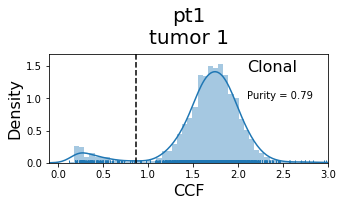

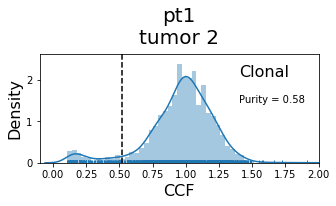

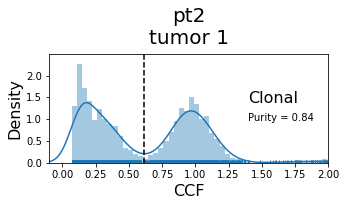

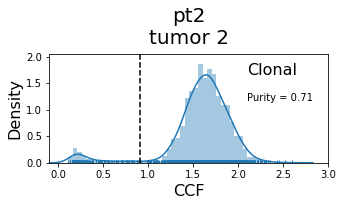

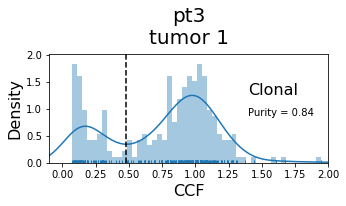

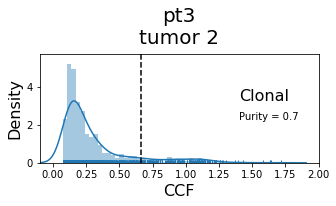

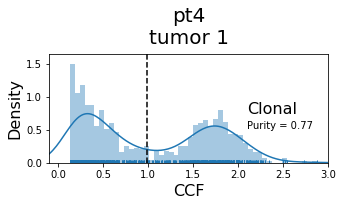

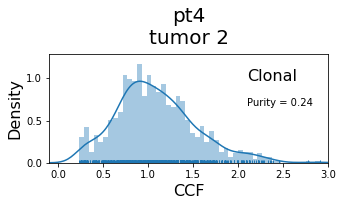

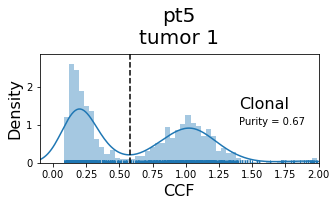

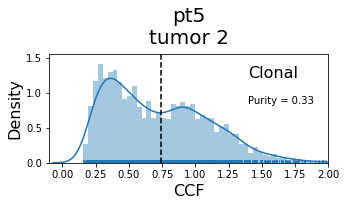

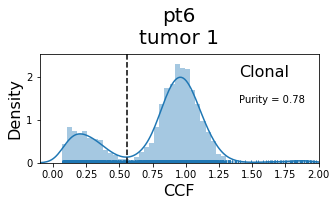

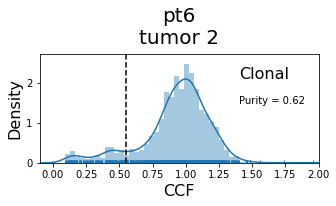

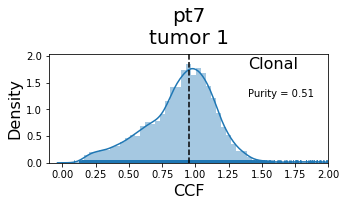

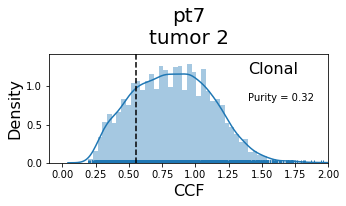

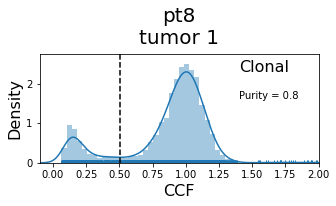

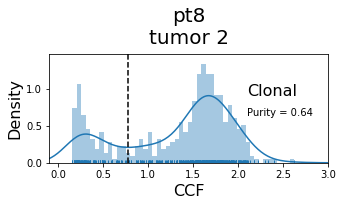

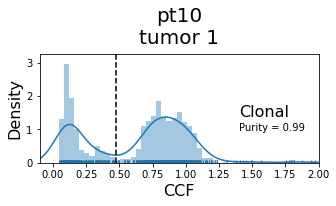

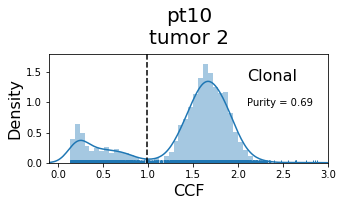

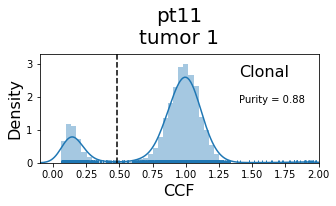

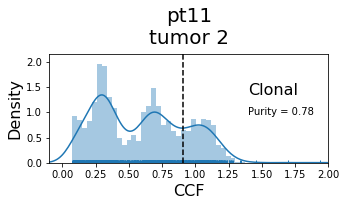

In [79]:
j = 0
for pt in pts:
    print(pt)
    for tumor in ['_t1','_t2']:
        if tumor == '_t1':
            title = pt+'\ntumor 1'
        else:
            title = pt+'\ntumor 2'
        sample_id = pt + tumor
        sample_df = samples_list[j]
        data = sample_df.copy(deep=False)
        if (pt == 'pt1' and tumor == '_t1') or (pt == 'pt2' and tumor == '_t2')or (pt == 'pt4' )or (pt == 'pt8' and tumor == '_t2')or (pt == 'pt10' and tumor == '_t2'):
            xlim2 = 3
        else:
            xlim2 = 2
        density_plot_poster(data,'t_CCF',title,xlim1=-0.1,xlim2=xlim2,bins=50, position=1.2,sample=sample_id)
        j = j +1


## VAF

### Mutect

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

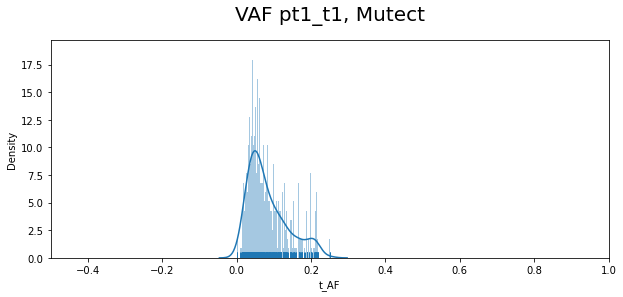

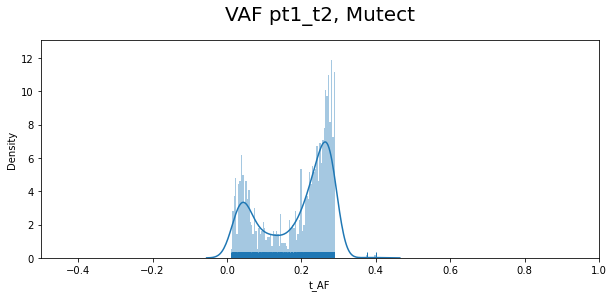

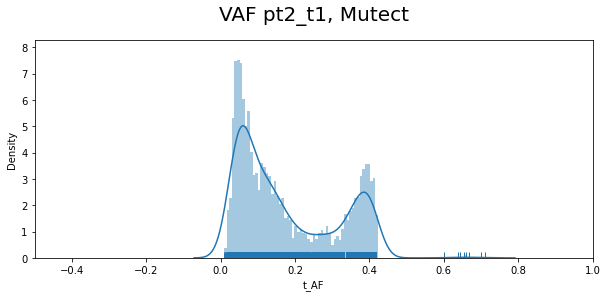

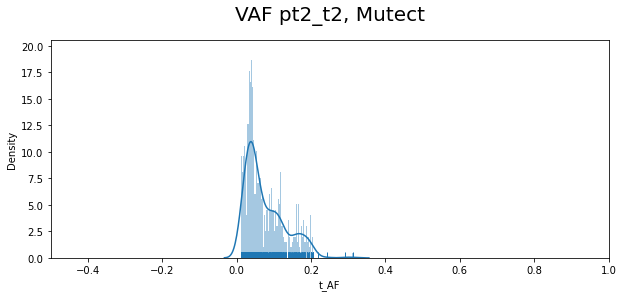

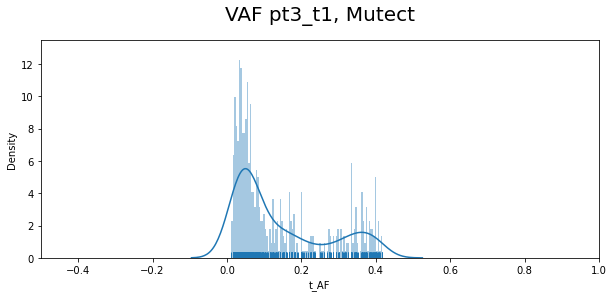

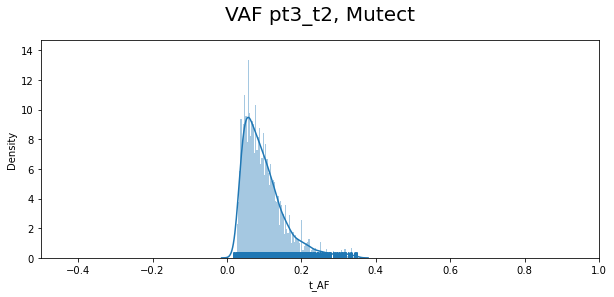

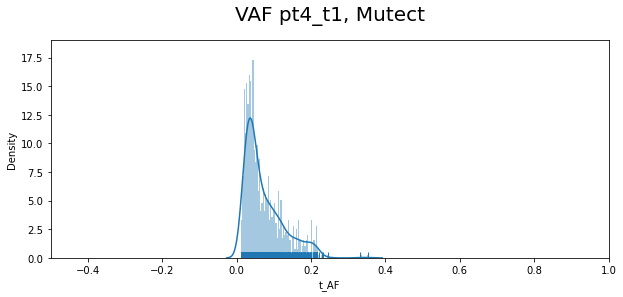

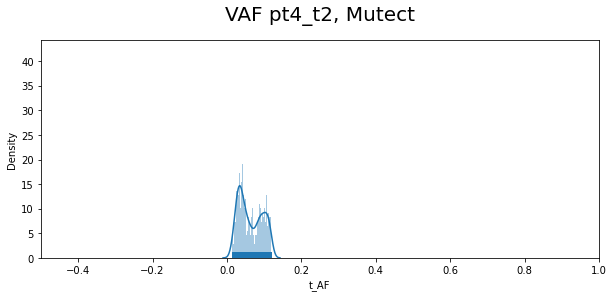

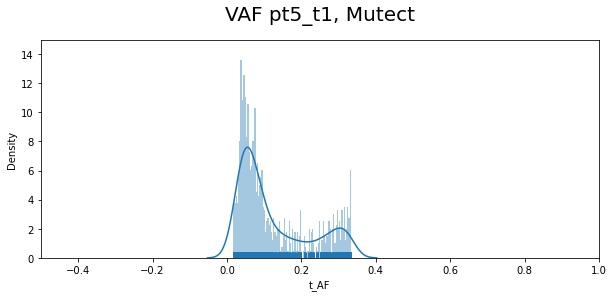

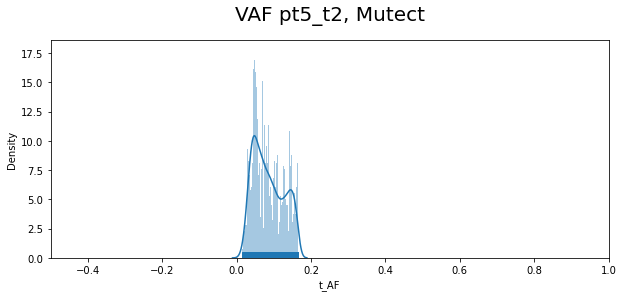

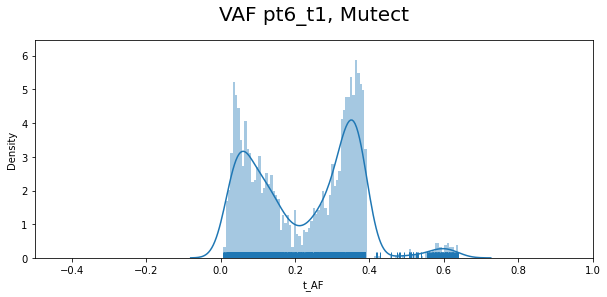

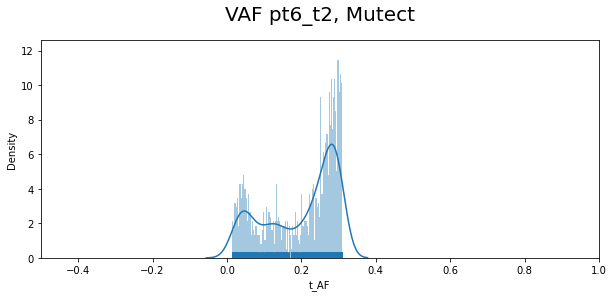

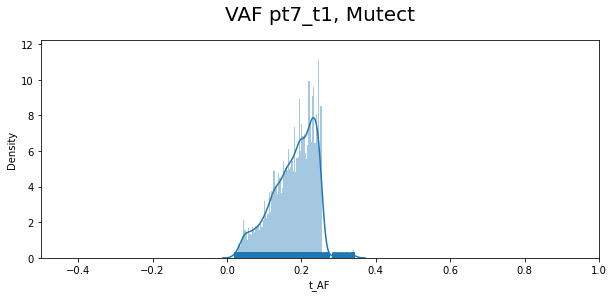

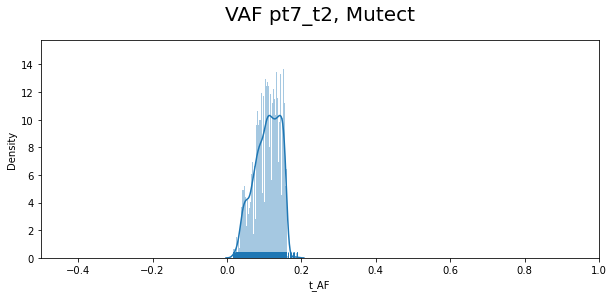

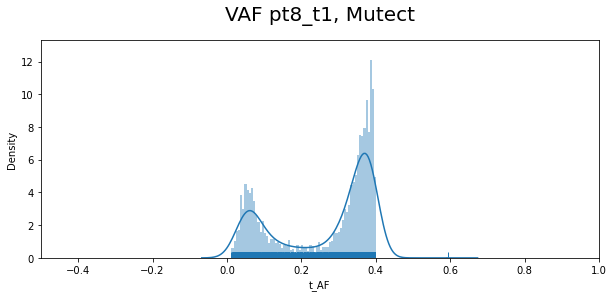

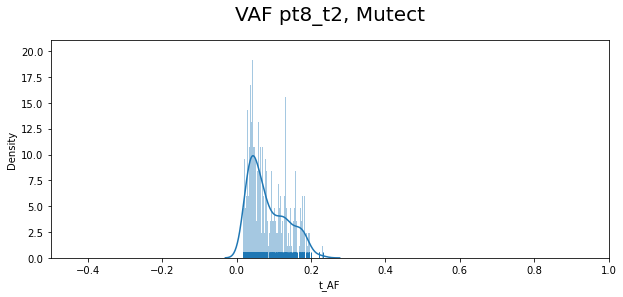

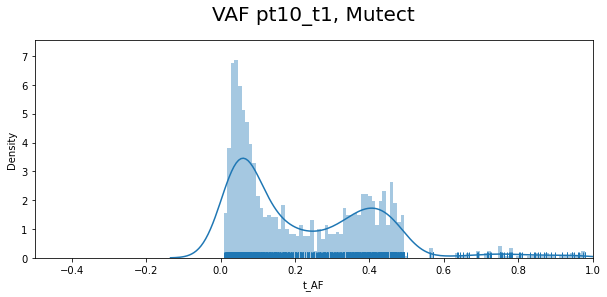

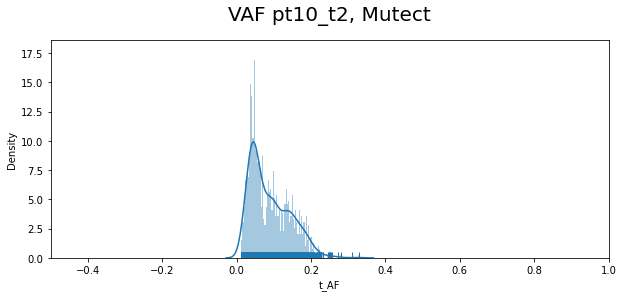

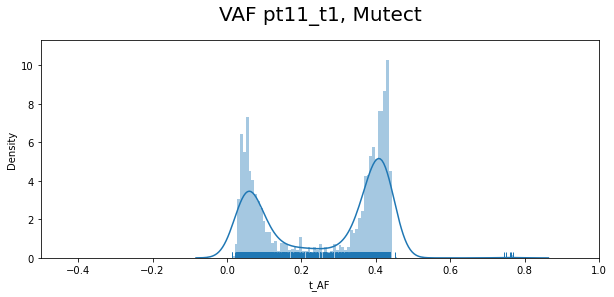

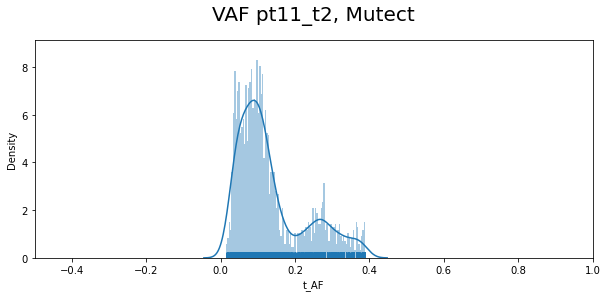

In [41]:
j = 0
for pt in pts:
    for tumor in ['_t1','_t2']:
        sample_id = pt + tumor
        title = 'VAF '+sample_id+', Mutect'
        sample_df = samples_mutect_list[j]
        data = sample_df.copy(deep=False)
        density_plot(data,'t_AF',title,1,pos=2.2,sample=sample_id,vaf=True)
        j = j +1

### Strelka

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

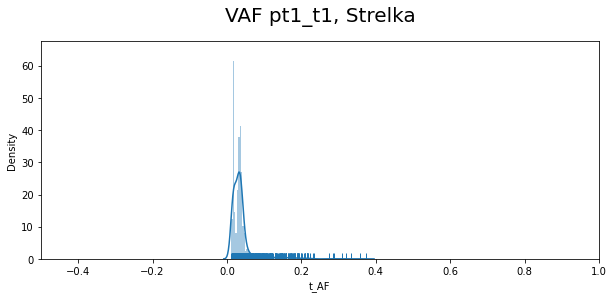

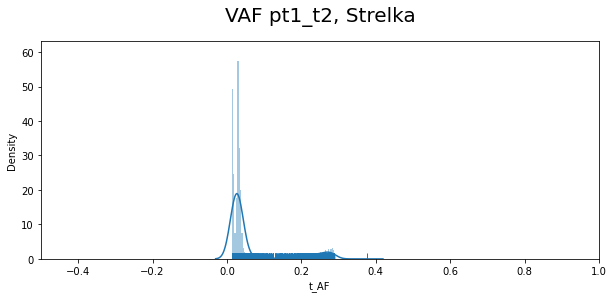

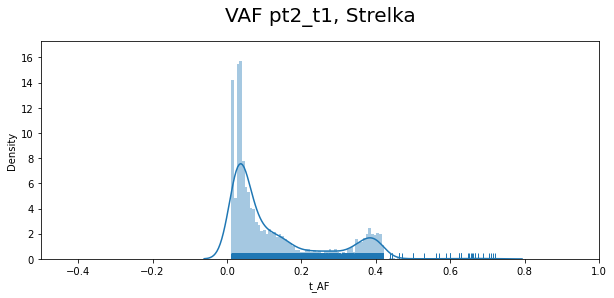

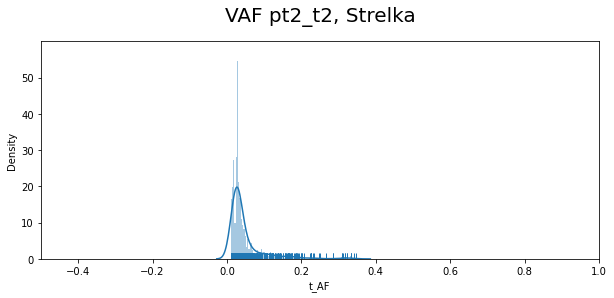

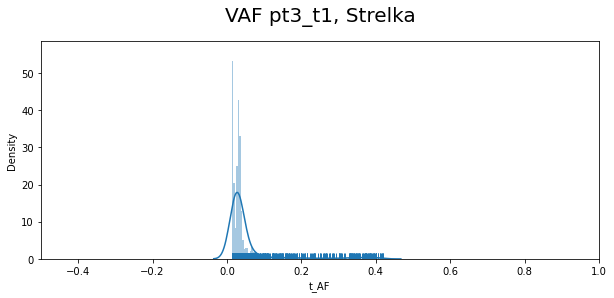

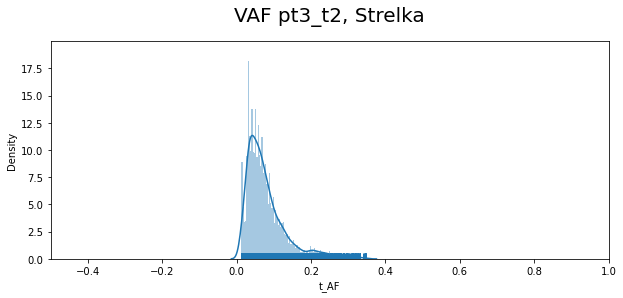

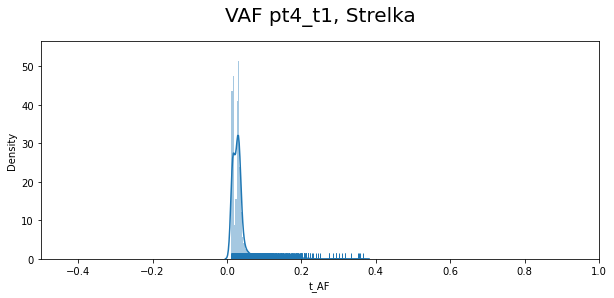

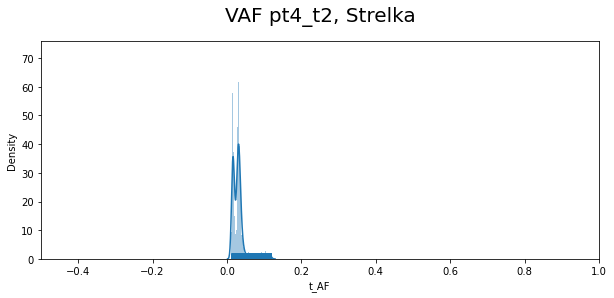

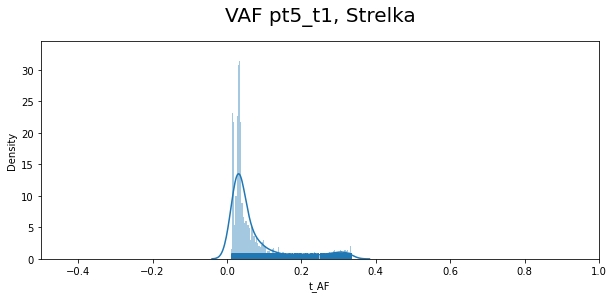

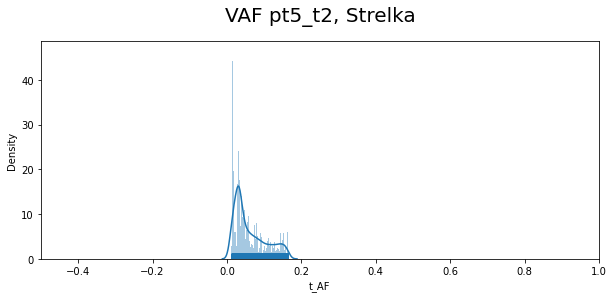

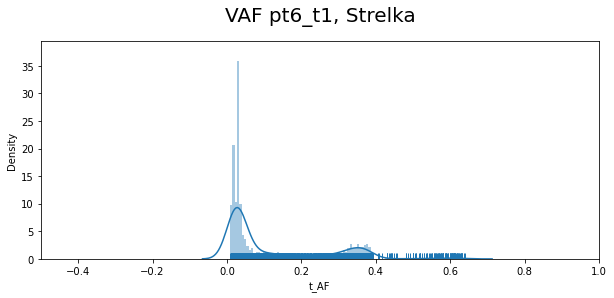

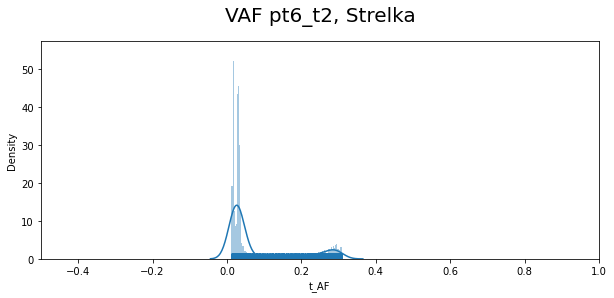

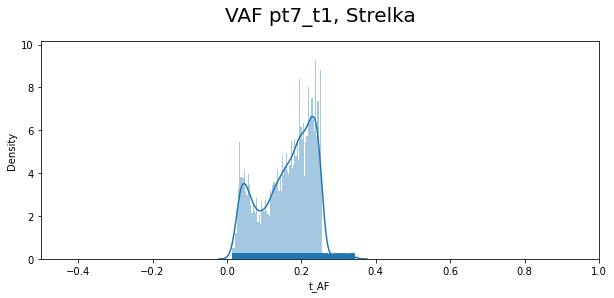

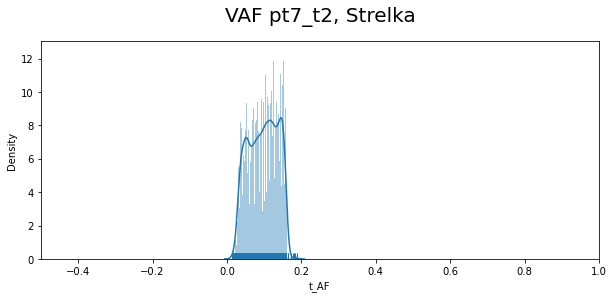

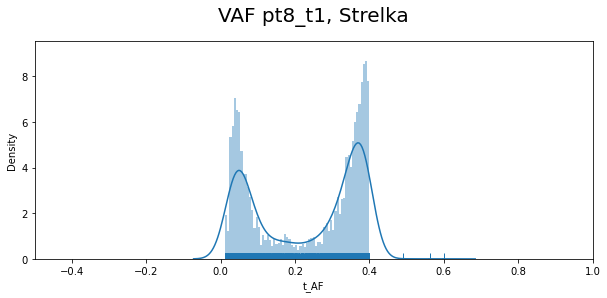

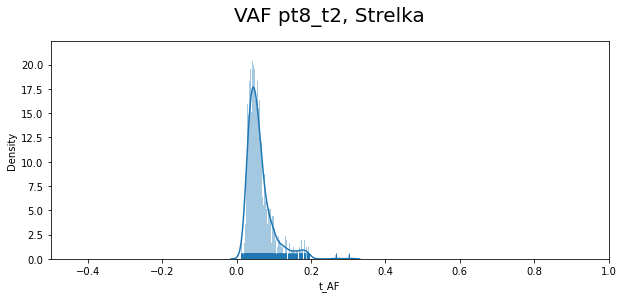

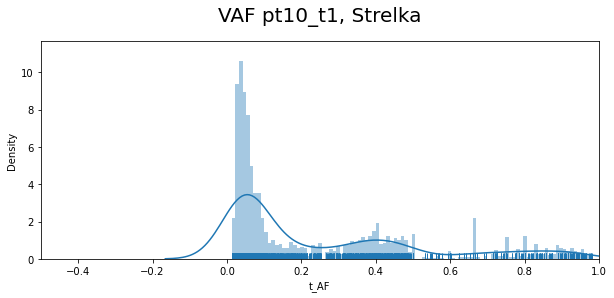

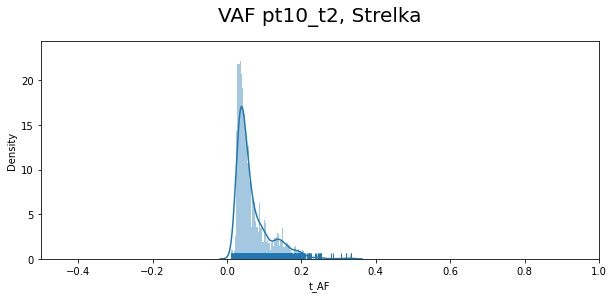

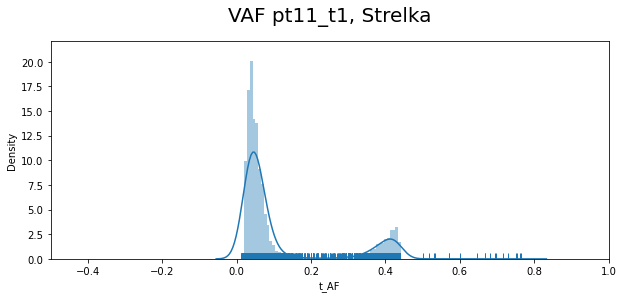

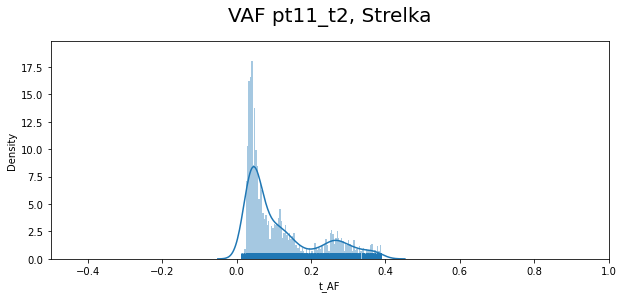

In [42]:
j = 0
for pt in pts:
    for tumor in ['_t1','_t2']:
        sample_id = pt + tumor
        title = 'VAF '+sample_id+', Strelka'
        sample_df = samples_strelka_list[j]
        data = sample_df.copy(deep=False)
        density_plot(data,'t_AF',title,1,pos=2.2,sample=sample_id,vaf=True)
        j = j +1

### SAGE

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

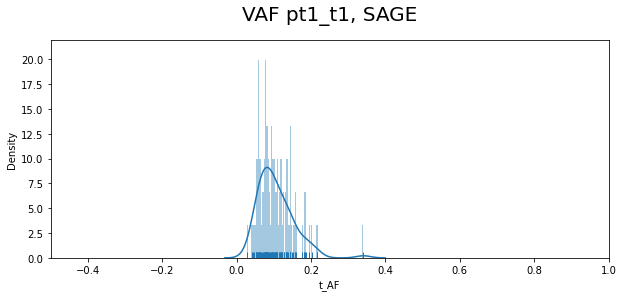

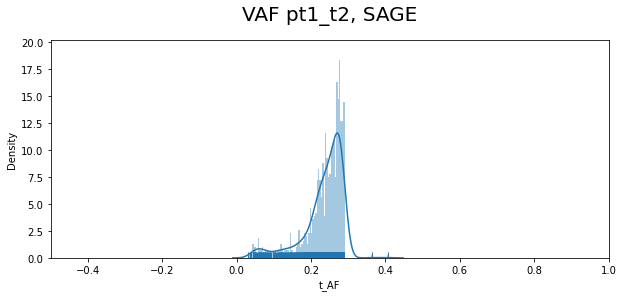

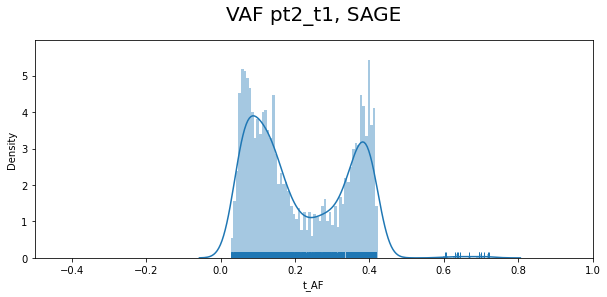

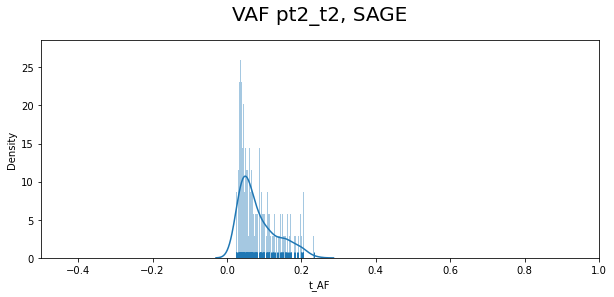

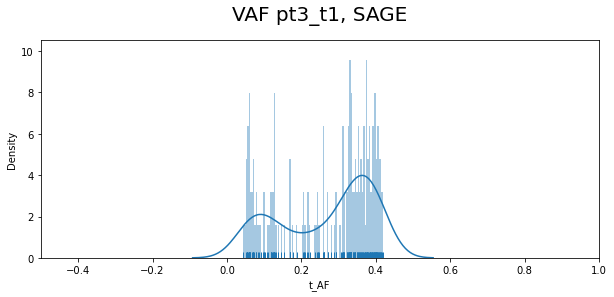

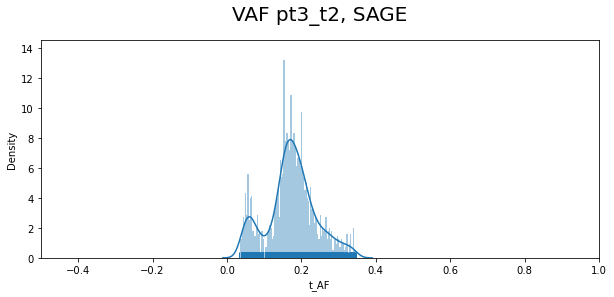

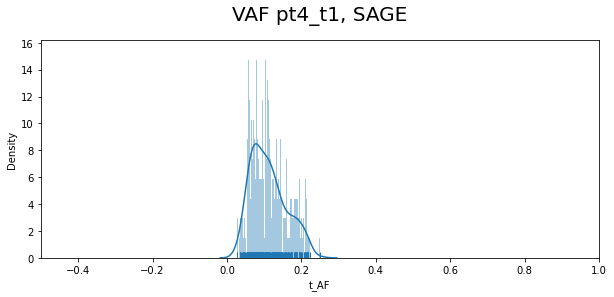

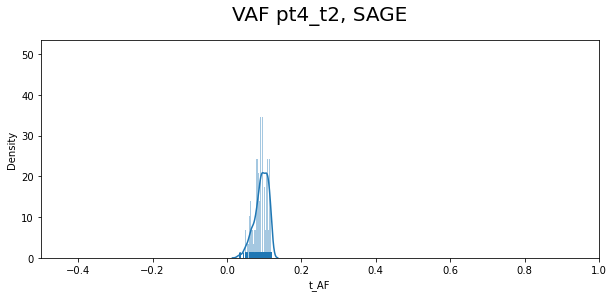

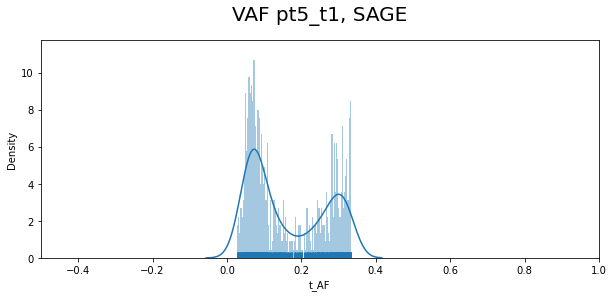

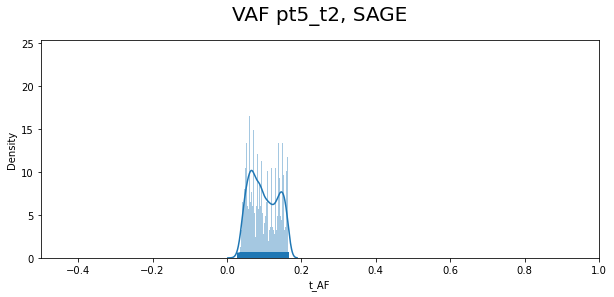

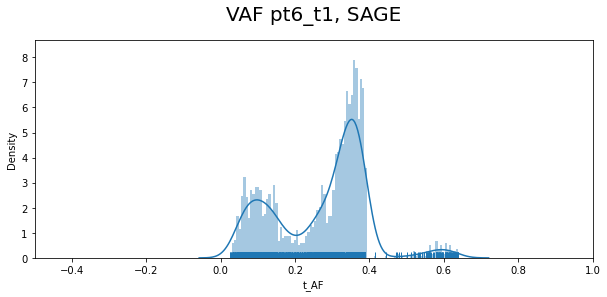

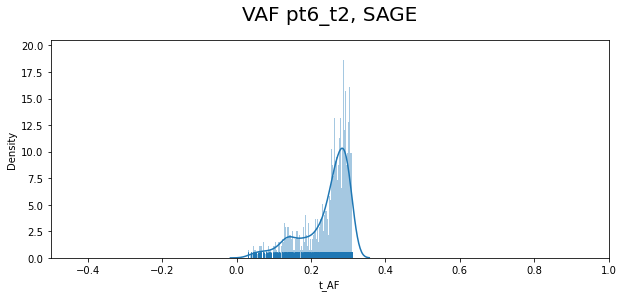

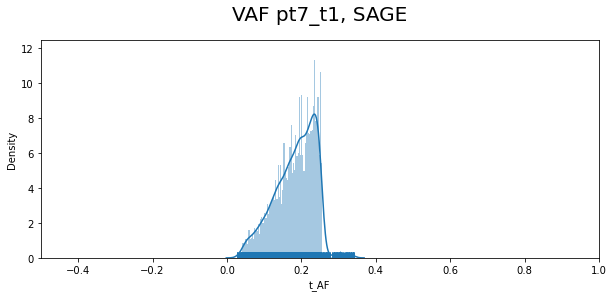

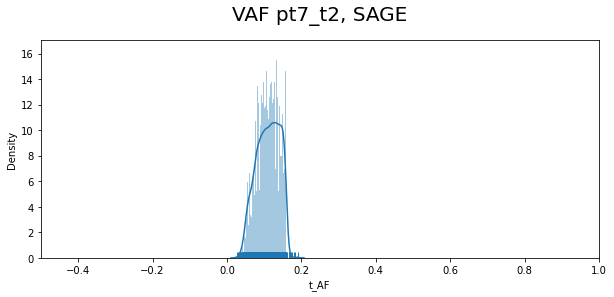

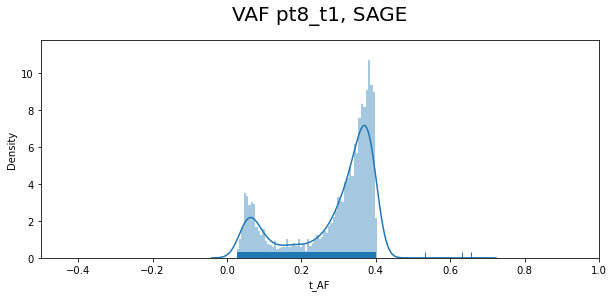

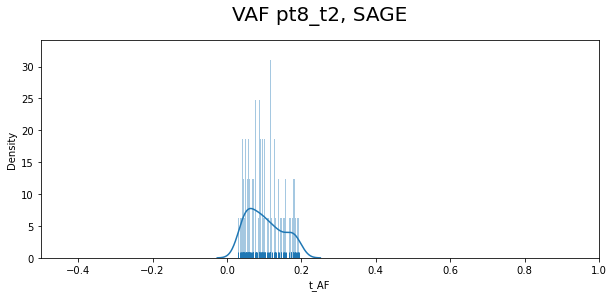

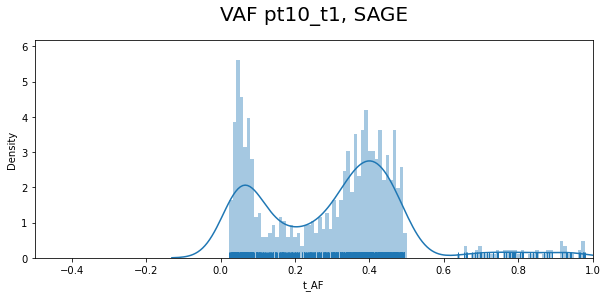

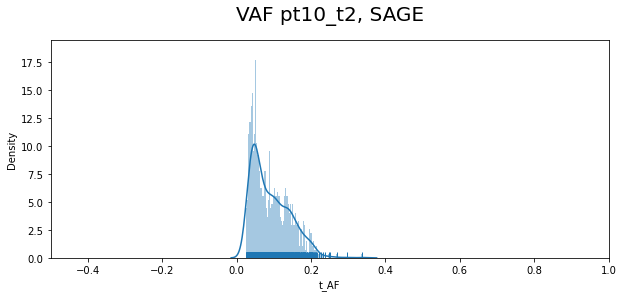

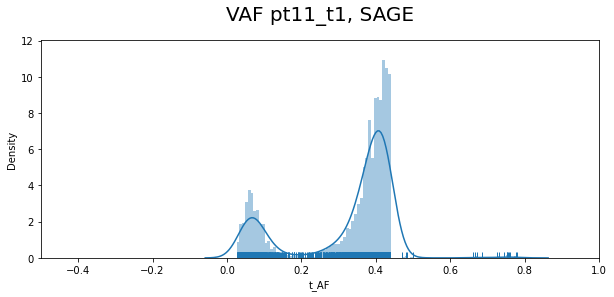

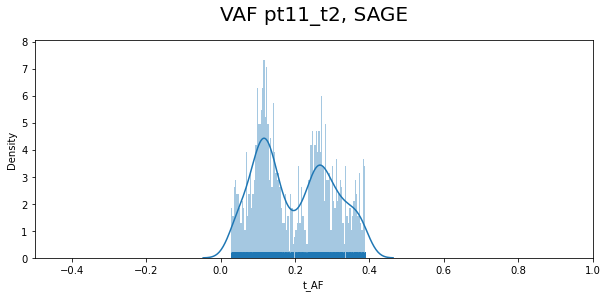

In [43]:
j = 0
for pt in pts:
    for tumor in ['_t1','_t2']:
        sample_id = pt + tumor
        title = 'VAF '+sample_id+', SAGE'
        sample_df = samples_sage_list[j]
        data = sample_df.copy(deep=False)
        density_plot(data,'t_AF',title,1,pos=2.2,sample=sample_id,vaf=True)
        j = j +1

### 2/3 intersect

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.

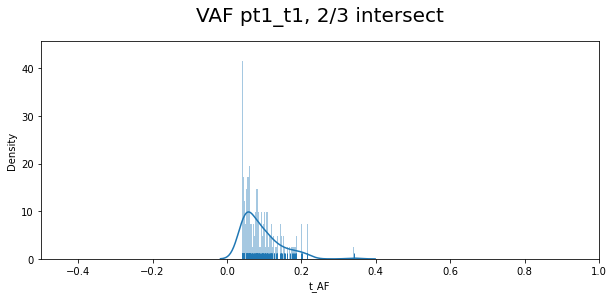

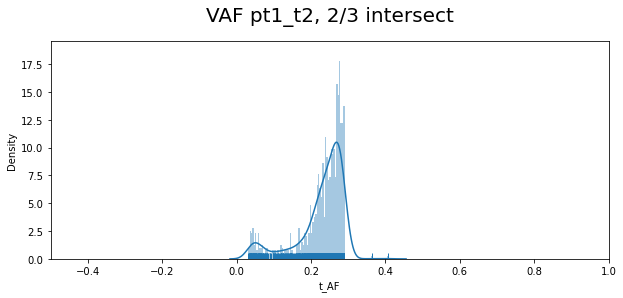

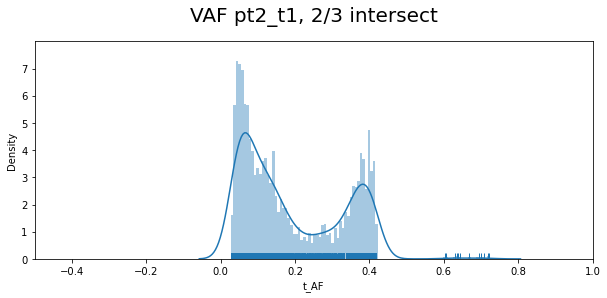

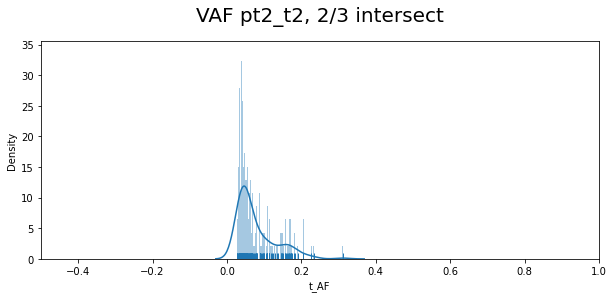

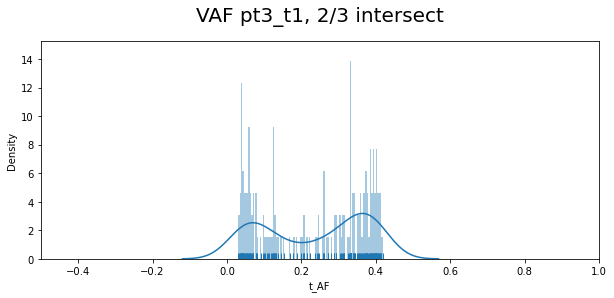

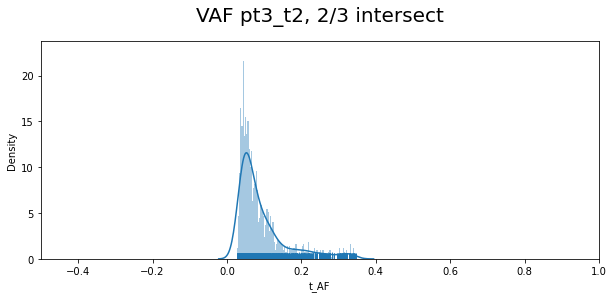

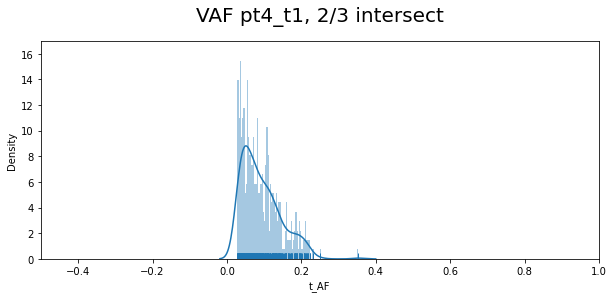

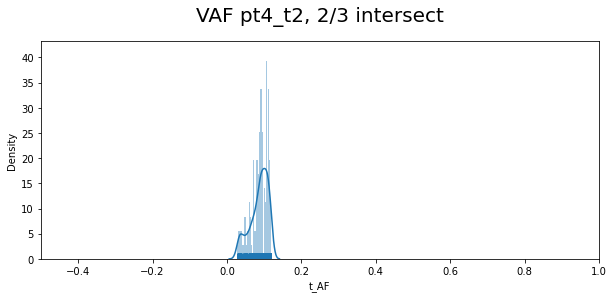

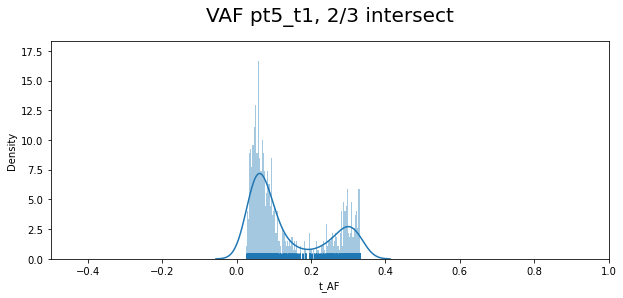

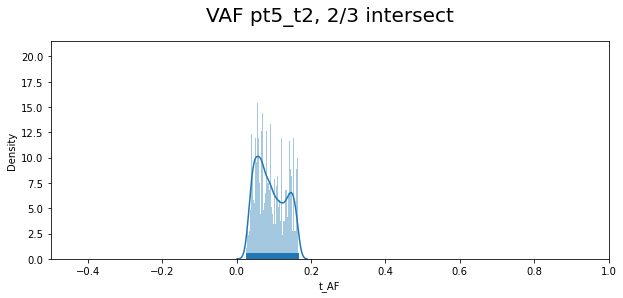

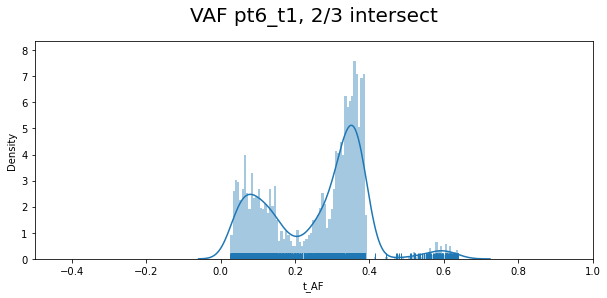

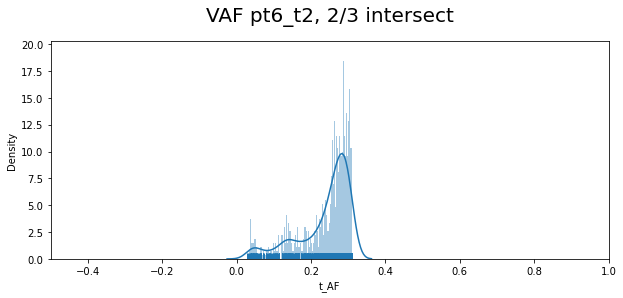

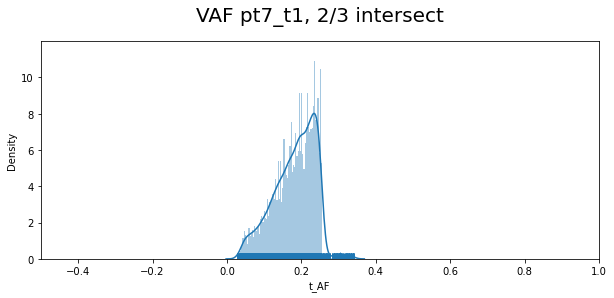

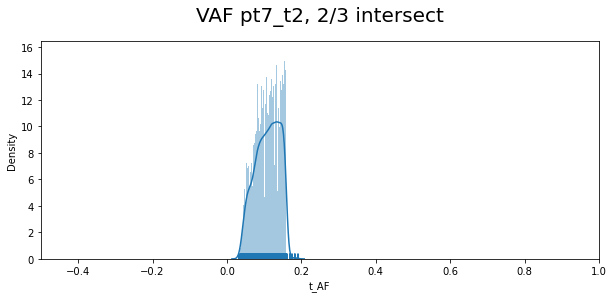

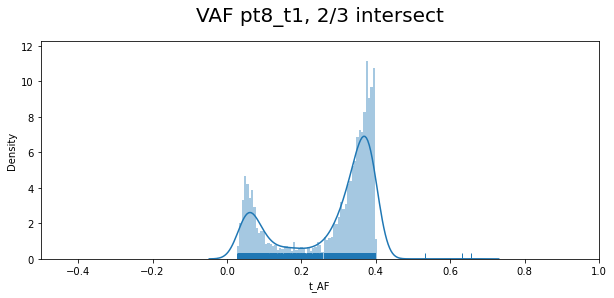

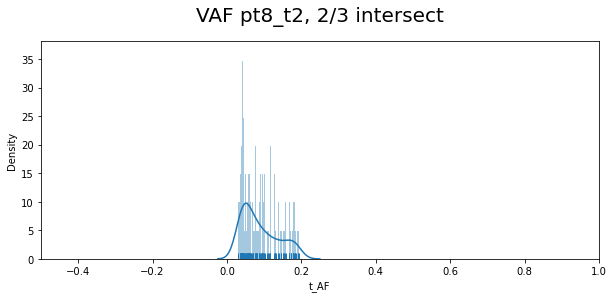

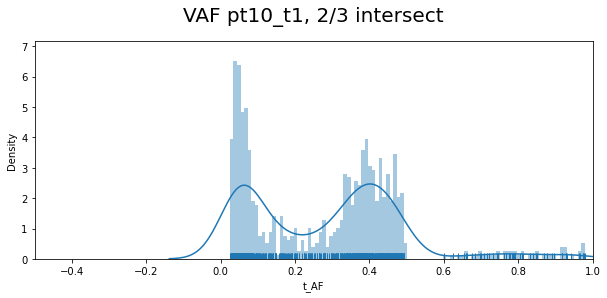

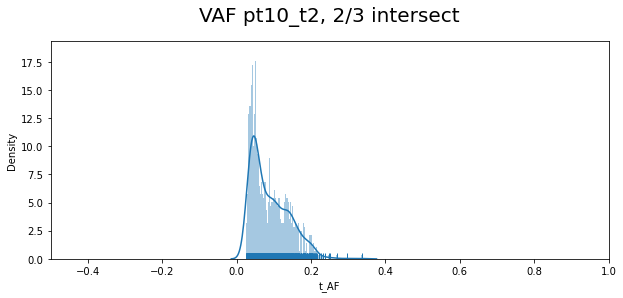

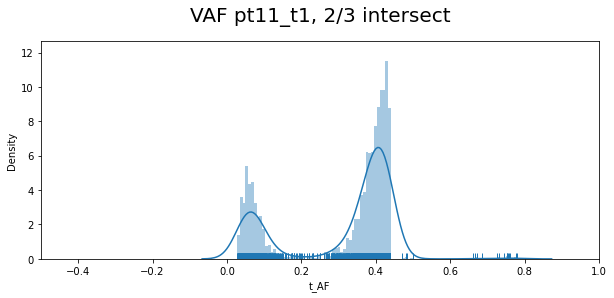

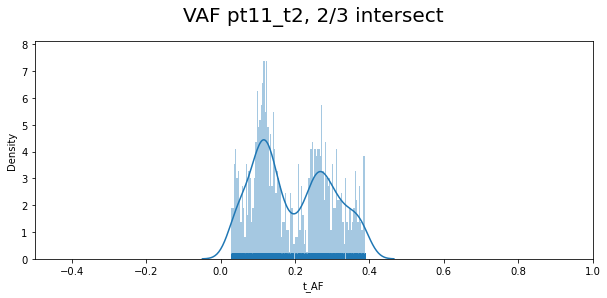

In [44]:
j = 0
for pt in pts:
    for tumor in ['_t1','_t2']:
        sample_id = pt + tumor
        title = 'VAF '+sample_id+', 2/3 intersect'
        sample_df = samples_list[j]
        data = sample_df.copy(deep=False)
        density_plot(data,'t_AF',title,1,pos=2.2,sample=sample_id,vaf=True)
        j = j +1

## Overlapp between tumors and callers of clonal alterations

In [45]:
def overlap_tables (t1_pass_df,t2_pass_df,indicator,left,right):
    '''function to get overlapped table between tumors'''
    t1_pass_df['Mutations'] = t1_pass_df['#CHROM'].astype(str)+'_' + t1_pass_df['POS'].astype(str)+ '_' + t1_pass_df['REF'].astype(str)+ '_' + t1_pass_df['ALT'].astype(str)
    t1_pass_df = t1_pass_df[['Mutations']]
    
    t2_pass_df['Mutations'] = t2_pass_df['#CHROM'].astype(str)+'_' + t2_pass_df['POS'].astype(str)+ '_' + t2_pass_df['REF'].astype(str)+ '_' + t2_pass_df['ALT'].astype(str)
    t2_pass_df = t2_pass_df[['Mutations']]
    
    df = pd.merge(t1_pass_df, t2_pass_df, how='outer', indicator=indicator)
    df['Tumor'] = df['Tumor'].replace({'left_only':left,'right_only':right})
    
    df = df.groupby(indicator,as_index=False).count()
    
    total = sum(df['Mutations'].tolist())
    
    df['Percent'] = round(df['Mutations']/total*100,2)
    
    return(df)

def venn_tumor_plots (t1_pass_df,t2_pass_df,title):
    '''function to get overlapped table between tumors'''
    t1_pass_df['Mutations'] = t1_pass_df['#CHROM'].astype(str)+'_' + t1_pass_df['POS'].astype(str)+ '_' + t1_pass_df['REF'].astype(str)+ '_' + t1_pass_df['ALT'].astype(str)
    t1_pass_list = t1_pass_df['Mutations'].tolist()
    
    t2_pass_df['Mutations'] = t2_pass_df['#CHROM'].astype(str)+'_' + t2_pass_df['POS'].astype(str)+ '_' + t2_pass_df['REF'].astype(str)+ '_' + t2_pass_df['ALT'].astype(str)
    t2_pass_list = t2_pass_df['Mutations'].tolist()
    
    set1 = set(t1_pass_list)
    set2 = set(t2_pass_list)
    
    plt.title(title, size=20)

    venn2([set1, set2], ('Tumor 1', 'Tumor 2'))
    plt.show()
    
def venn_caller_plots (t1_pass_df,t2_pass_df,t3_pass_df,title):
    '''function to get overlapped table between tumors'''
    t1_pass_df['Mutations'] = t1_pass_df['#CHROM'].astype(str)+'_' + t1_pass_df['POS'].astype(str)+ '_' + t1_pass_df['REF'].astype(str)+ '_' + t1_pass_df['ALT'].astype(str)
    t1_pass_list = t1_pass_df['Mutations'].tolist()
    
    t2_pass_df['Mutations'] = t2_pass_df['#CHROM'].astype(str)+'_' + t2_pass_df['POS'].astype(str)+ '_' + t2_pass_df['REF'].astype(str)+ '_' + t2_pass_df['ALT'].astype(str)
    t2_pass_list = t2_pass_df['Mutations'].tolist()
    
    t3_pass_df['Mutations'] = t3_pass_df['#CHROM'].astype(str)+'_' + t3_pass_df['POS'].astype(str)+ '_' + t3_pass_df['REF'].astype(str)+ '_' + t3_pass_df['ALT'].astype(str)
    t3_pass_list = t3_pass_df['Mutations'].tolist()
    
    set1 = set(t1_pass_list)
    set2 = set(t2_pass_list)
    set3 = set(t3_pass_list)
    
    plt.title(title, size=20)

    venn3([set1, set2,set3], ('Mutect2', 'Strelka','SAGE'))
    plt.show()

### Mutect2

In [49]:
tumors_dict = {'Tumor 1':'_t1','Tumor 2':'_t2'}

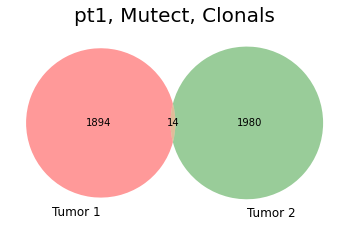

Tumor  Mutations  Percent
0  Tumor1       1894    48.71
1  Tumor2       1980    50.93
2    both         14     0.36

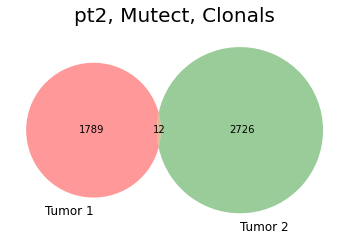

Tumor  Mutations  Percent
0  Tumor1       1789    39.52
1  Tumor2       2726    60.22
2    both         12     0.27

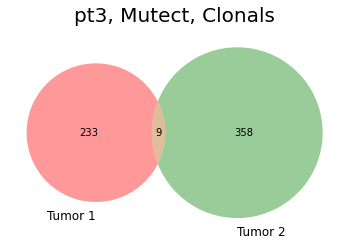

Tumor  Mutations  Percent
0  Tumor1        233    38.83
1  Tumor2        358    59.67
2    both          9     1.50

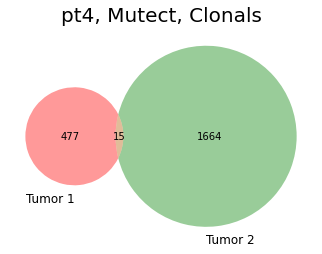

Tumor  Mutations  Percent
0  Tumor1        477    22.12
1  Tumor2       1664    77.18
2    both         15     0.70

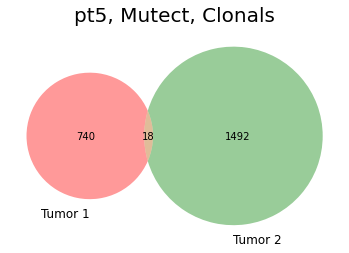

Tumor  Mutations  Percent
0  Tumor1        740    32.89
1  Tumor2       1492    66.31
2    both         18     0.80

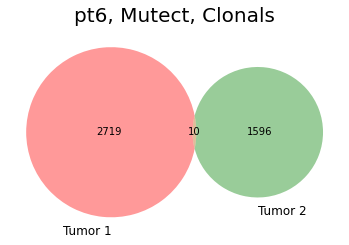

Tumor  Mutations  Percent
0  Tumor1       2719    62.87
1  Tumor2       1596    36.90
2    both         10     0.23

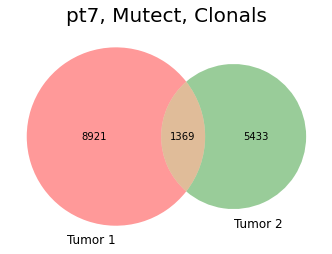

Tumor  Mutations  Percent
0  Tumor1       8921    56.74
1  Tumor2       5433    34.55
2    both       1369     8.71

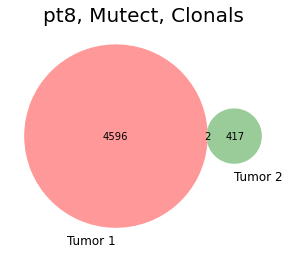

Tumor  Mutations  Percent
0  Tumor1       4596    91.65
1  Tumor2        417     8.32
2    both          2     0.04

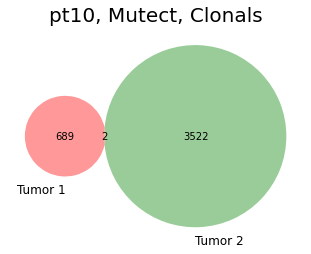

Tumor  Mutations  Percent
0  Tumor1        689    16.35
1  Tumor2       3522    83.60
2    both          2     0.05

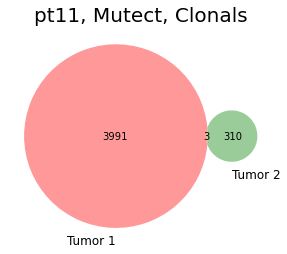

Tumor  Mutations  Percent
0  Tumor1       3991    92.73
1  Tumor2        310     7.20
2    both          3     0.07

In [51]:
import warnings
warnings.filterwarnings('ignore')
j = 0
for pt in pts:
    df1 = samples_mutect_list[j]
    t = tumors_dict['Tumor 1']
    sample_id = pt + t
    t = thresholds[sample_id]
    df1 = df1[df1['t_CCF']>t]
    j = j+1
    df2 = samples_mutect_list[j]
    t = tumors_dict['Tumor 2']
    sample_id = pt + t
    t = thresholds[sample_id]
    df2 = df2[df2['t_CCF']>t]
    df = overlap_tables(df1,df2,'Tumor','Tumor1','Tumor2')
    venn_tumor_plots(df1,df2,pt+', Mutect, Clonals')
    j = j +1
    display(df)

### Strelka

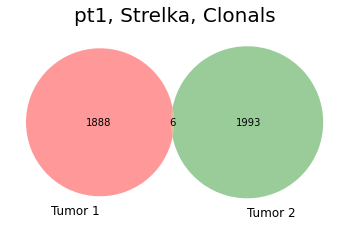

Tumor  Mutations  Percent
0  Tumor1       1888    48.57
1  Tumor2       1993    51.27
2    both          6     0.15

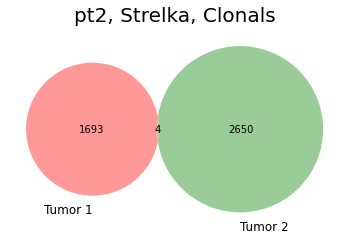

Tumor  Mutations  Percent
0  Tumor1       1693    38.95
1  Tumor2       2650    60.96
2    both          4     0.09

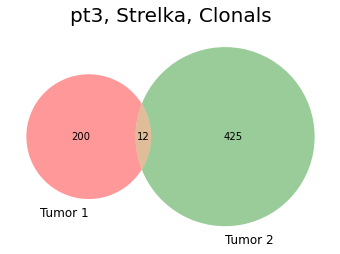

Tumor  Mutations  Percent
0  Tumor1        200    31.40
1  Tumor2        425    66.72
2    both         12     1.88

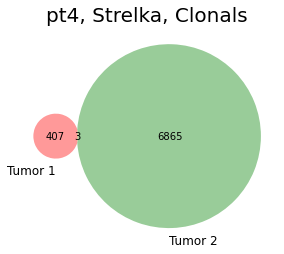

Tumor  Mutations  Percent
0  Tumor1        407     5.59
1  Tumor2       6865    94.36
2    both          3     0.04

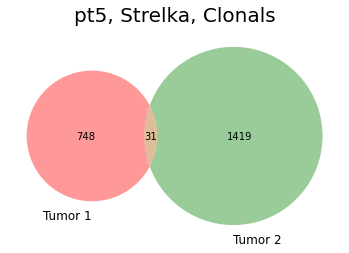

Tumor  Mutations  Percent
0  Tumor1        748    34.03
1  Tumor2       1419    64.56
2    both         31     1.41

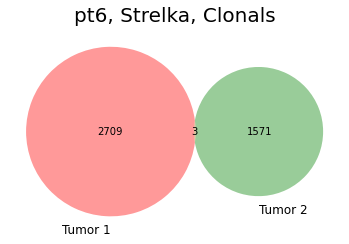

Tumor  Mutations  Percent
0  Tumor1       2709    63.25
1  Tumor2       1571    36.68
2    both          3     0.07

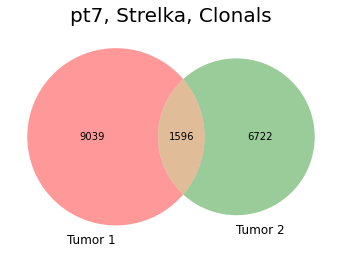

Tumor  Mutations  Percent
0  Tumor1       9039    52.08
1  Tumor2       6722    38.73
2    both       1596     9.20

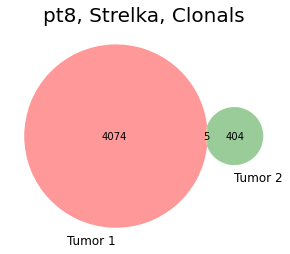

Tumor  Mutations  Percent
0  Tumor1       4074    90.88
1  Tumor2        404     9.01
2    both          5     0.11

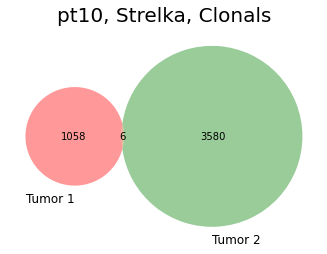

Tumor  Mutations  Percent
0  Tumor1       1058    22.78
1  Tumor2       3580    77.09
2    both          6     0.13

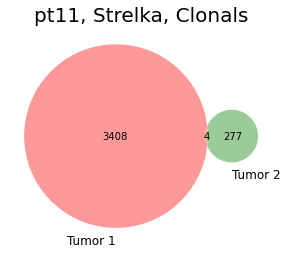

Tumor  Mutations  Percent
0  Tumor1       3408    92.38
1  Tumor2        277     7.51
2    both          4     0.11

In [53]:
import warnings
warnings.filterwarnings('ignore')
j = 0
for pt in pts:
    df1 = samples_strelka_list[j]
    t = tumors_dict['Tumor 1']
    sample_id = pt + t
    t = thresholds[sample_id]
    df1 = df1[df1['t_CCF']>t]
    j = j+1
    df2 = samples_strelka_list[j]
    t = tumors_dict['Tumor 2']
    sample_id = pt + t
    t = thresholds[sample_id]
    df2 = df2[df2['t_CCF']>t]
    df = overlap_tables(df1,df2,'Tumor','Tumor1','Tumor2')
    venn_tumor_plots(df1,df2,pt+', Strelka, Clonals')
    j = j +1
    display(df)

### SAGE

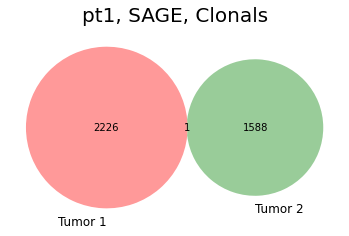

Tumor  Mutations  Percent
0  Tumor1       2226    58.35
1  Tumor2       1588    41.63
2    both          1     0.03

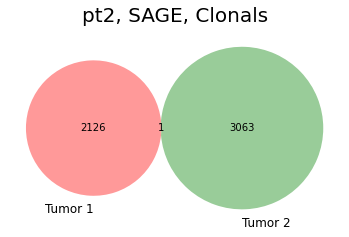

Tumor  Mutations  Percent
0  Tumor1       2127    40.97
1  Tumor2       3063    59.01
2    both          1     0.02

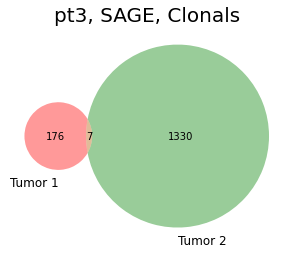

Tumor  Mutations  Percent
0  Tumor1        176    11.59
1  Tumor2       1335    87.94
2    both          7     0.46

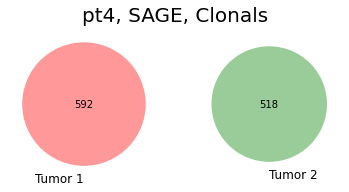

Tumor  Mutations  Percent
0  Tumor1        592    53.33
1  Tumor2        518    46.67

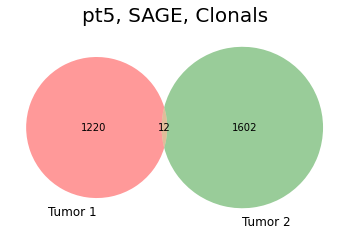

Tumor  Mutations  Percent
0  Tumor1       1222    43.09
1  Tumor2       1602    56.49
2    both         12     0.42

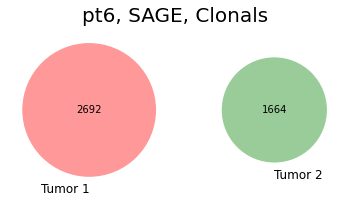

Tumor  Mutations  Percent
0  Tumor1       2692     61.8
1  Tumor2       1664     38.2

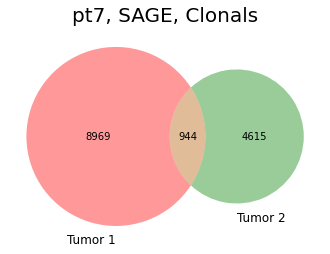

Tumor  Mutations  Percent
0  Tumor1       8971    61.73
1  Tumor2       4617    31.77
2    both        944     6.50

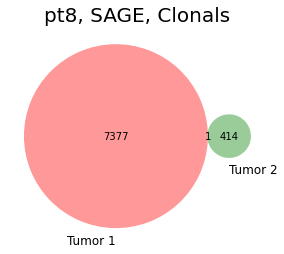

Tumor  Mutations  Percent
0  Tumor1       7387    94.68
1  Tumor2        414     5.31
2    both          1     0.01

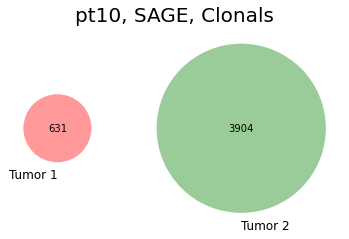

Tumor  Mutations  Percent
0  Tumor1        631     13.9
1  Tumor2       3907     86.1

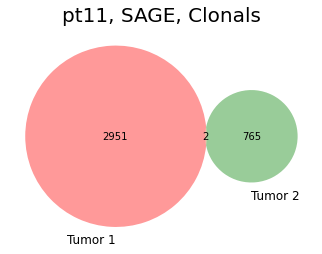

Tumor  Mutations  Percent
0  Tumor1       2956    79.27
1  Tumor2        770    20.65
2    both          3     0.08

In [55]:
import warnings
warnings.filterwarnings('ignore')
j = 0
for pt in pts:
    df1 = samples_sage_list[j]
    df1 = df1[df1['t_CCF']>t]
    t = tumors_dict['Tumor 1']
    sample_id = pt + t
    t = thresholds[sample_id]
    j = j+1
    df2 = samples_sage_list[j]
    df2 = df2[df2['t_CCF']>t]
    t = tumors_dict['Tumor 2']
    sample_id = pt + t
    t = thresholds[sample_id]
    df = overlap_tables(df1,df2,'Tumor','Tumor1','Tumor2')
    venn_tumor_plots(df1,df2,pt+', SAGE, Clonals')
    j = j +1
    display(df)

### Overlapp between callers

### All clonals

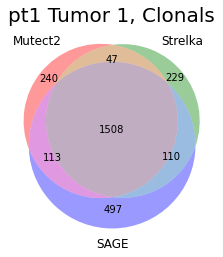

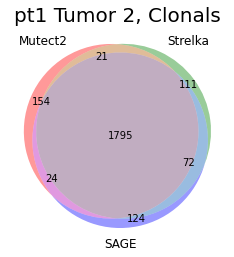

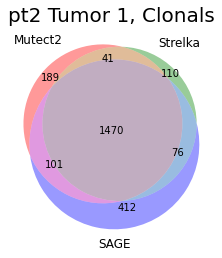

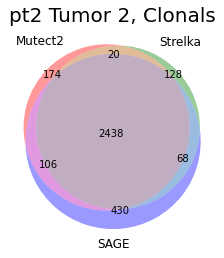

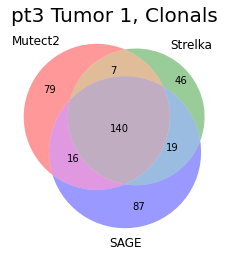

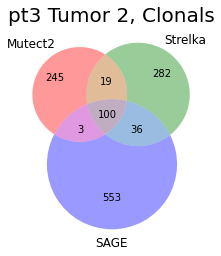

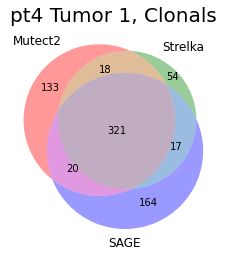

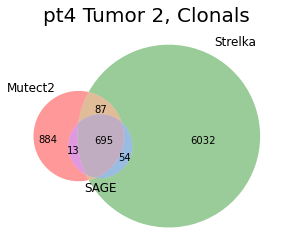

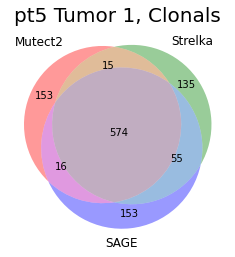

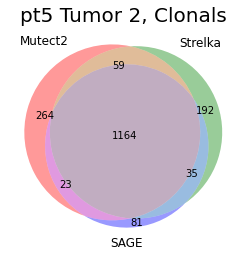

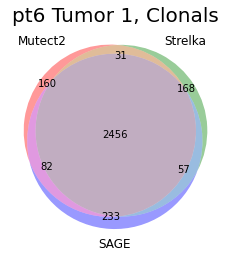

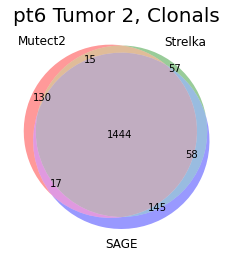

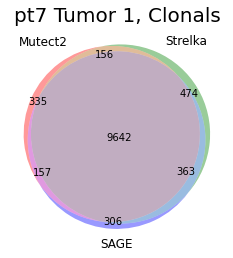

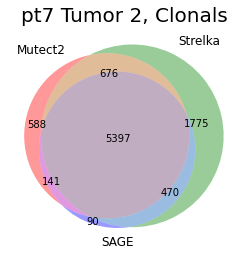

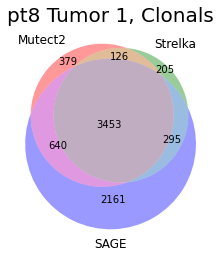

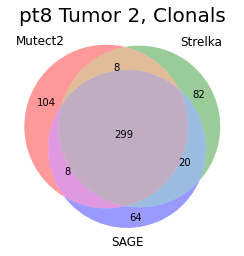

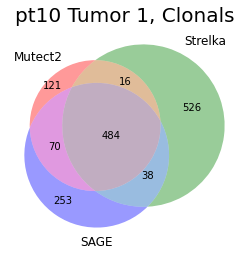

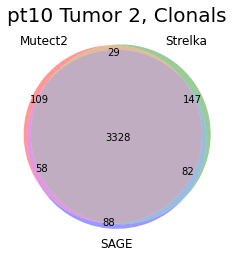

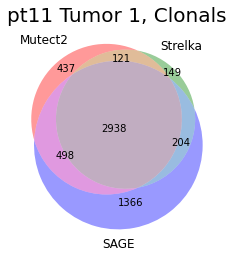

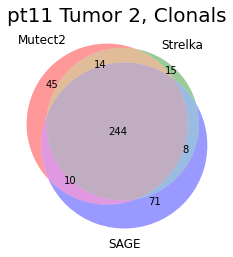

In [59]:
import warnings
warnings.filterwarnings('ignore')
j = 0
for pt in pts:
    for tumor in ['Tumor 1','Tumor 2']:
        df1 = samples_mutect_list[j]
        df2 = samples_strelka_list[j]
        df3 = samples_sage_list[j]
        t = tumors_dict[tumor]
        sample_id = pt + t
        t = thresholds[sample_id]
        df1 = df1[df1['t_CCF']>t]
        df2 = df2[df2['t_CCF']>t]
        df3 = df3[df3['t_CCF']>t]
        venn_caller_plots(df1,df2,df3,pt+' '+tumor+', Clonals')
        j = j +1

### Clonals, SNVs

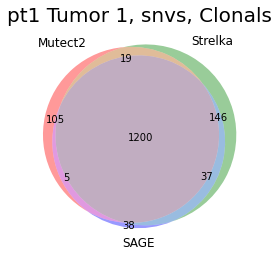

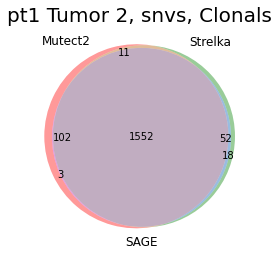

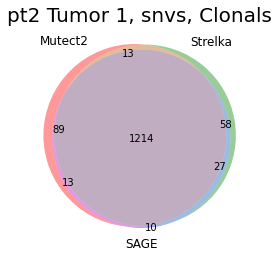

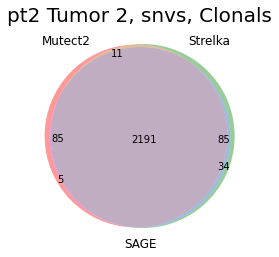

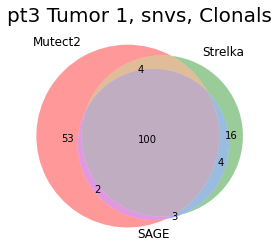

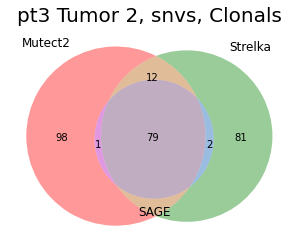

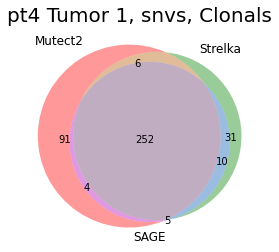

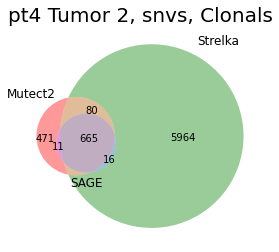

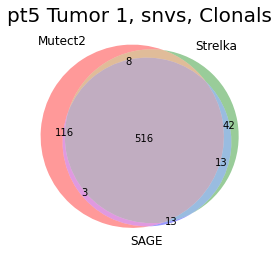

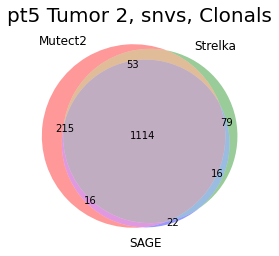

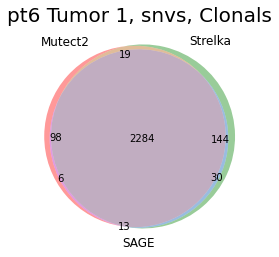

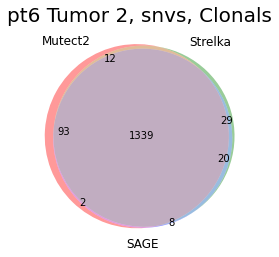

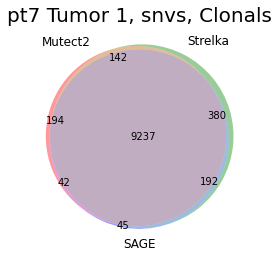

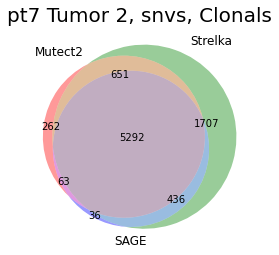

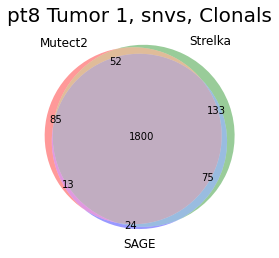

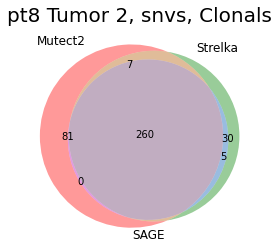

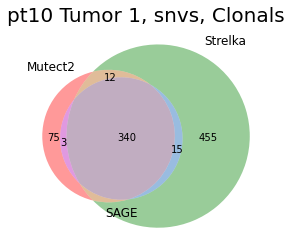

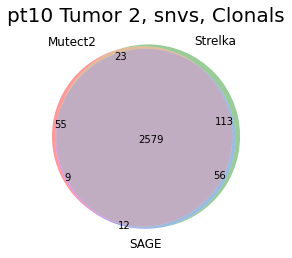

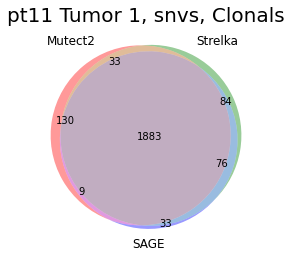

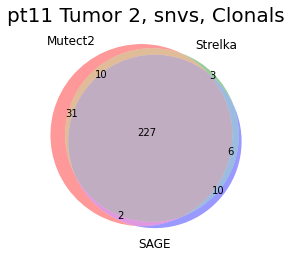

In [57]:
import warnings
warnings.filterwarnings('ignore')
j = 0
for pt in pts:
    for tumor in ['Tumor 1','Tumor 2']:
        df1 = samples_mutect_list[j]
        df2 = samples_strelka_list[j]
        df3 = samples_sage_list[j]
        t = tumors_dict[tumor]
        sample_id = pt + t
        t = thresholds[sample_id]
        df1 = df1[(df1['t_CCF']>t)&(df1['mut_type']=='snv')]
        df2 = df2[(df2['t_CCF']>t)&(df2['mut_type']=='snv')]
        df3 = df3[(df3['t_CCF']>t)&(df3['mut_type']=='snv')]
        venn_caller_plots(df1,df2,df3,pt+' '+tumor+', snvs, Clonals')
        j = j +1

### Clonals, Indels

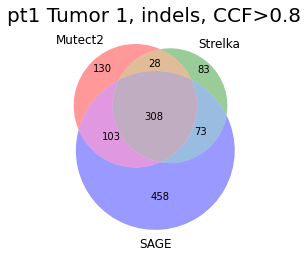

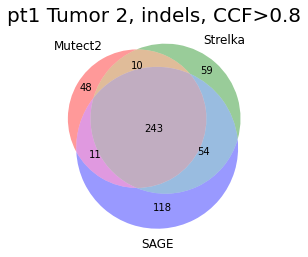

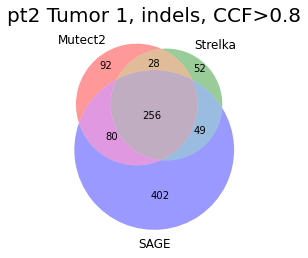

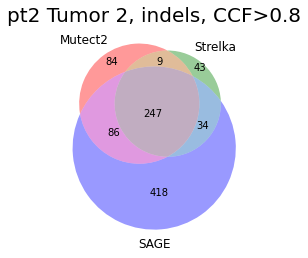

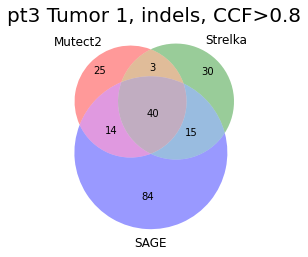

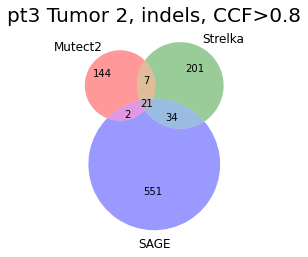

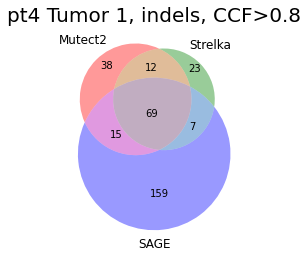

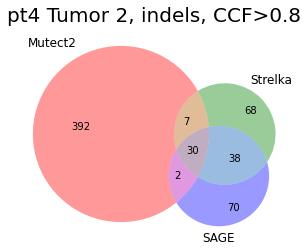

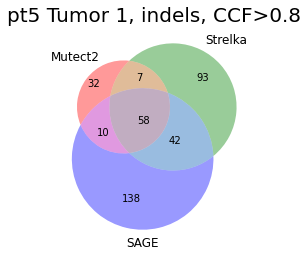

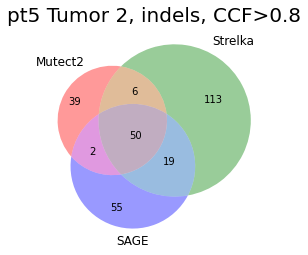

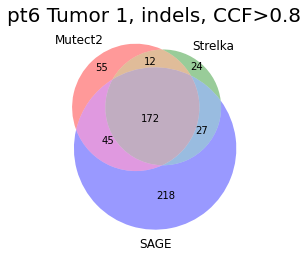

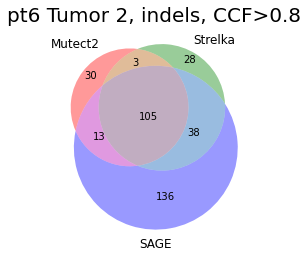

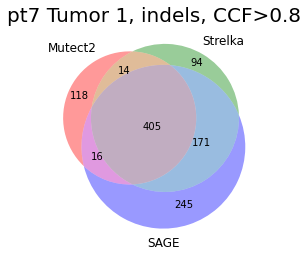

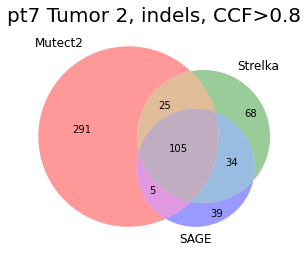

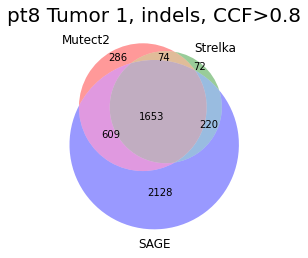

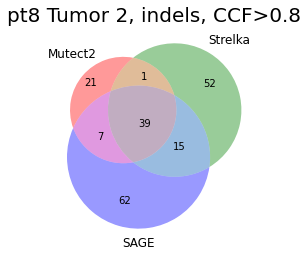

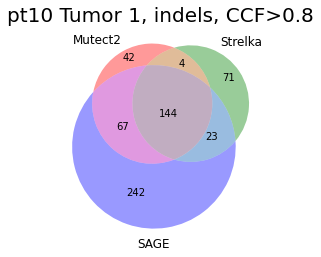

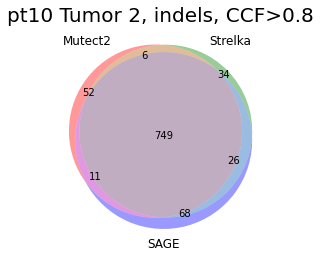

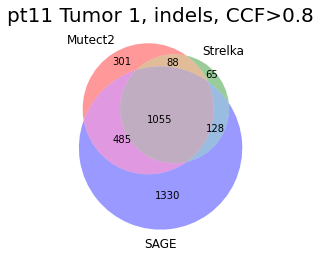

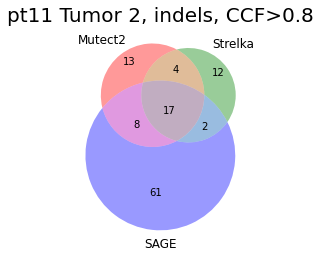

In [58]:
import warnings
warnings.filterwarnings('ignore')
j = 0
for pt in pts:
    for tumor in ['Tumor 1','Tumor 2']:
        df1 = samples_mutect_list[j]
        df2 = samples_strelka_list[j]
        df3 = samples_sage_list[j]
        t = tumors_dict[tumor]
        sample_id = pt + t
        t = thresholds[sample_id]
        df1 = df1[(df1['t_CCF']>t)&(df1['mut_type']=='indel')]
        df2 = df2[(df2['t_CCF']>t)&(df2['mut_type']=='indel')]
        df3 = df3[(df3['t_CCF']>t)&(df3['mut_type']=='indel')]
        venn_caller_plots(df1,df2,df3,pt+' '+tumor+', indels, CCF>0.8')
        j = j +1

### Plot figures for paper

In [30]:
ylim1=0
ylim2=2
list(range(ylim1, ylim2+1, 1))

[0, 1, 2]

In [83]:
def density_plot_paper (data,y_var,xlim1,xlim2,ylim1,ylim2,yticks,xticks,bins=100,position=2,vaf=False):
    '''Create density plot for CCF
    input: tumor data, title and xlim max
    output: plot()'''
    
    def slope(data_y,data_x,i):
        slope = (data_y[i+1] - data_y[i]) / (data_x[i+1] - data_x[i])
        return slope
    purity = data['purity'][0]    
    data = data[(~data[y_var].isnull())&(data['t_CCF']<xlim2)]
    data = data[y_var]
    plt.figure(figsize=(3, 2))
    ax = sns.distplot(data,rug=True,bins=bins)
    plt.xlim(xlim1,xlim2)
    plt.yticks(yticks)
    plt.xticks(xticks)
    plt.ylabel('Density', fontsize=16)
    plt.xlabel('CCF', fontsize=16)
    if vaf==False:
        data_x, data_y = ax.lines[0].get_data()

        poss = []
        for i in range(len(data_y)):
            if i == 0 or i == (len(data_y)-1):
                pass
            else:
                if sample == 'pt1_t2':
                    if  slope(data_y,data_x,i)<0.8 and slope(data_y,data_x,i)>0.7:
                        pos = i
                        poss.append(pos)
                elif sample == 'pt3_t2':
                    if  slope(data_y,data_x,i)<-0.8 and slope(data_y,data_x,i)>-0.9:
                        pos = i
                        poss.append(pos)
                else:
                    if (data_y[i] < data_y[i+1]) and (data_y[i] < data_y[i-1]):
                        poss.append(i)
                        print(data_y[i],i)

        poss = [pos for pos in poss if data_x[pos] <1]
        if poss == []:
            pos = 0
        else:
            pos = max(poss)
        
        print(data_x[pos],data_y[pos])

        plt.axvline(x = data_x[pos],color='k',linewidth=1.5,linestyle='--')

        mpl.rcParams['axes.spines.right'] = False
        mpl.rcParams['axes.spines.top'] = False

In [84]:
import matplotlib as mpl
import numpy as np

In [88]:
tumor = 'AQ5180'
normal = 'AQ5174'
pt = 'pt1'
t = 't1'

snvs_df = pd.read_csv('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/'
                      +pt+'/'+tumor+'_vs_'+normal+'/process_vep_output/'
                      +tumor+'_vs_'+normal+'.maf.gz',sep='\t')
cnv_df = pd.read_csv('/workspace/datasets/sjd_seq/platinum_results/20220809/'
                         +pt+'-'+t+'-allsamples-'+t+'/purple/'
                         +tumor+'.purple.cnv.somatic.tsv',sep='\t')      


#Get df with cn and snv intersect
df = cnv_snvs_intersect(cnv_df,snvs_df,caller_cn='purple')


df = pt1_t1_df.copy(deep=True)
def calculate_VAF(reads_alt,reads_ref):
    '''Calculate VAF from number of reads
    input: number of reads alternate allele, number of reads reference allele
    output: variant allele frequency'''
    if reads_alt == reads_ref == 0:
        return 0
    else:
        vaf = round (reads_alt/(reads_alt+reads_ref),3)
        return vaf

def calculate_ccf (vaf,cnv,purity):
    '''Calculate CCF from VAF, CN and purity
    input: variant allele frequency, copy number, purity
    output: cancer cell fraction'''
    ccf = vaf*(purity*cnv+ (1-purity)*2)/purity
    return ccf

#Calculate AF and CCF
purity = pd.read_csv('/workspace/datasets/sjd_seq/platinum_results/20220809/'
                     +pt+'-'+t+'-allsamples-'+t+'/purple/'
                     +tumor+'.purple.purity.tsv',sep='\t')
#Get purity
purity = purity['purity'][0]


df['t_AF'] = df.apply(lambda row: calculate_VAF(row['t_alt_reads'],row['t_ref_reads']),axis=1)
df['n_AF'] = df.apply(lambda row: calculate_VAF(row['n_alt_reads'],row['n_ref_reads']),axis=1)
df['t_CCF'] = df.apply(lambda row: calculate_ccf(row['t_AF'],row['CN'],purity),axis=1)
df['n_CCF'] = df.apply(lambda row: calculate_ccf(row['n_AF'],row['CN'],purity),axis=1)

In [89]:
df[['t_AF','t_CCF','CN','purity']]

t_AF     t_CCF      CN  purity
0     0.667  1.038483  1.0253    0.79
1     0.647  1.007344  1.0253    0.79
2     0.341  0.530918  1.0253    0.79
3     0.648  1.008901  1.0253    0.79
4     0.094  0.146353  1.0253    0.79
...     ...       ...     ...     ...
1913  0.300  0.747944  1.9615    0.79
1914  0.362  0.902519  1.9615    0.79
1915  0.347  0.865122  1.9615    0.79
1916  0.371  0.924957  1.9615    0.79
1917  0.352  0.877587  1.9615    0.79

[1918 rows x 4 columns]

In [90]:
pt1_t1_df[['t_AF','t_CCF','CN','purity']]

t_AF     t_CCF      CN  purity
0     0.667  1.038483  1.0253    0.79
1     0.647  1.007344  1.0253    0.79
2     0.341  0.530918  1.0253    0.79
3     0.648  1.008901  1.0253    0.79
4     0.094  0.146353  1.0253    0.79
...     ...       ...     ...     ...
1913  0.300  0.747944  1.9615    0.79
1914  0.362  0.902519  1.9615    0.79
1915  0.347  0.865122  1.9615    0.79
1916  0.371  0.924957  1.9615    0.79
1917  0.352  0.877587  1.9615    0.79

[1918 rows x 4 columns]

In [91]:
pt1_t2_df[['t_AF','t_CCF','CN','purity']]

t_AF     t_CCF      CN  purity
0     0.296  1.029806  2.0308    0.58
1     0.304  1.057639  2.0308    0.58
2     0.266  0.925434  2.0308    0.58
3     0.298  1.036765  2.0308    0.58
4     0.276  0.960225  2.0308    0.58
...     ...       ...     ...     ...
2044  0.277  0.934120  1.9240    0.58
2045  0.171  0.576659  1.9240    0.58
2046  0.302  1.018427  1.9240    0.58
2047  0.383  1.291582  1.9240    0.58
2048  0.333       NaN     NaN    0.58

[2049 rows x 4 columns]

In [92]:
pt3_t1_df[['t_AF','t_CCF','CN','purity']]

t_AF     t_CCF      CN  purity
0    0.241  0.574436  2.0026    0.84
1    0.500  1.191776  2.0026    0.84
2    0.333  0.793723  2.0026    0.84
3    0.422  1.005859  2.0026    0.84
4    0.421  1.003476  2.0026    0.84
..     ...       ...     ...     ...
257  0.550  0.757434  0.9962    0.84
258  0.159  0.219253  0.9980    0.84
259  0.540  0.744634  0.9980    0.84
260  0.462  0.634396  0.9922    0.84
261  0.935  1.283897  0.9922    0.84

[262 rows x 4 columns]

In [93]:
pt3_t2_df[['t_AF','t_CCF','CN','purity']]

t_AF     t_CCF      CN  purity
0     0.034  0.096925  1.9936     0.7
1     0.035  0.099776  1.9936     0.7
2     0.053  0.151089  1.9936     0.7
3     0.082  0.233761  1.9936     0.7
4     0.051  0.145388  1.9936     0.7
...     ...       ...     ...     ...
1415  0.077  0.142654  0.9955     0.7
1416  0.094  0.174148  0.9955     0.7
1417  0.730  1.352429  0.9955     0.7
1418  0.804  1.489525  0.9955     0.7
1419  0.067  0.124127  0.9955     0.7

[1420 rows x 4 columns]

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


0.05318093505751958 66
0.48330933468304726 0.05318093505751958


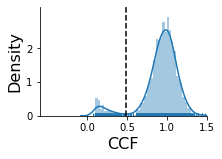

In [172]:
sample_id=''
data = pt1_t1_df.copy(deep=False)

xlim1 = -0.6
xlim2 = 1.5
yticks = np.arange (0, 3, 1)
xticks = np.arange(0, 2, 0.5)

density_plot_paper(data,'t_CCF',xlim1=xlim1,xlim2=xlim2,ylim1=0,ylim2=ylim2,xticks=xticks,yticks=yticks,bins=50, position=0)        
plt.savefig('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt1/AQ5180_vs_AQ5174/pt1_t1_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()


In [130]:
threshold = thresholds['pt1_t1']

df = pt1_t1_df.copy()

df['clonal'] = df['t_CCF'].apply(lambda x: True if x > threshold else False)

df = df[(df['mut_type']=='snv')&(df['gnomADg_AF']<1)].drop_duplicates(subset=['#CHROM','POS','REF','ALT'])
df.groupby('clonal').count()

#CHROM   POS    ID   REF   ALT  QUAL  FILTER  INFO  FORMAT  NORMAL  \
clonal                                                                       
False      128   128   128   128   128   128     128   128     128     128   
True      1252  1252  1252  1252  1252  1252    1252  1252    1252    1252   

        ...  PHENO  gnomADg  gnomADg_AF  gnomADg_NFE  subset_origin  SAMPLE  \
clonal  ...                                                                   
False   ...    128      128         128          128            128     128   
True    ...   1252     1252        1252         1252           1252    1252   

          CN  t_CCF  n_CCF  purity  
clonal                              
False    128    128    128     128  
True    1252   1252   1252    1252  

[2 rows x 59 columns]

pt1, t2
0.10041030974190725 45
0.3497017805641155 0.10041030974190725


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


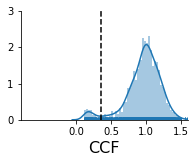

In [174]:
print('pt1, t2')
data = pt1_t2_df.copy(deep=False)

xlim1 = -0.8
xlim2 = 1.6
yticks = np.arange (0, 3+1, 1)
xticks = np.arange(0, 2, 0.5)

density_plot_paper(data,'t_CCF',xlim1=xlim1,xlim2=xlim2,ylim1=0,ylim2=3,xticks=xticks,yticks=yticks,bins=50, position=1.2)        
plt.ylabel('')
plt.savefig('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt1/AQ5186_vs_AQ5174/pt1_t2_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

In [143]:
threshold = thresholds['pt1_t2']

pt1_t2_df['clonal'] = pt1_t2_df['t_CCF'].apply(lambda x: True if x >= threshold else False)
pt1_t2_df[(pt1_t2_df['mut_type']=='snv')&(pt1_t2_df['gnomADg_AF']<1)].groupby('clonal').count()

#CHROM   POS    ID   REF   ALT  QUAL  FILTER  INFO  FORMAT  NORMAL  \
clonal                                                                       
False      122   122   122   122   122   122     122   122     122     122   
True      1579  1579  1579  1579  1579  1579    1579  1579    1579    1579   

        ...  PHENO  gnomADg  gnomADg_AF  gnomADg_NFE  subset_origin  SAMPLE  \
clonal  ...                                                                   
False   ...    122      122         122          122            122     122   
True    ...   1579     1579        1579         1579           1579    1579   

          CN  t_CCF  n_CCF  purity  
clonal                              
False    121    121    121     122  
True    1579   1579   1579    1579  

[2 rows x 59 columns]

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


0.2191862592859426 65
0.013207126712537624 141
0.6138108281107222 0.2191862592859426


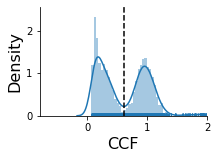

In [144]:
data = pt2_t1_df.copy(deep=False)

sample_id = 'pt2_t1'

xlim1 = -0.8
xlim2 = 2
yticks = np.arange (0, 3, 1)
xticks = np.arange(0, 3, 1)

density_plot_paper(data,'t_CCF',xlim1=xlim1,xlim2=xlim2,ylim1=0,ylim2=ylim2,xticks=xticks,yticks=yticks,bins=50, position=1.2)        
plt.savefig('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt2/AQ5181_vs_AQ5175/pt2_t1_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()


In [154]:
threshold = thresholds['pt2_t1']

pt2_t1_df['clonal'] = pt2_t1_df['t_CCF'].apply(lambda x: True if x >= threshold else False)
pt2_t1_df[(pt2_t1_df['mut_type']=='snv')&(pt2_t1_df['gnomADg_AF']<1)].groupby('clonal').count()

#CHROM   POS    ID   REF   ALT  QUAL  FILTER  INFO  FORMAT  NORMAL  \
clonal                                                                       
False     1644  1644  1644  1644  1644  1644    1644  1644    1644    1644   
True      1259  1259  1259  1259  1259  1259    1259  1259    1259    1259   

        ...  PHENO  gnomADg  gnomADg_AF  gnomADg_NFE  subset_origin  SAMPLE  \
clonal  ...                                                                   
False   ...   1644     1644        1644         1644           1644    1644   
True    ...   1259     1259        1259         1259           1259    1259   

          CN  t_CCF  n_CCF  purity  
clonal                              
False   1643   1643   1643    1644  
True    1259   1259   1259    1259  

[2 rows x 59 columns]

pt2, t2
0.05948826959771973 50
0.0519940513967927 71
0.5313739186352617 0.0519940513967927


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


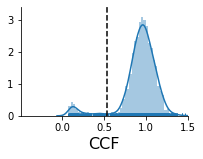

In [164]:
print('pt2, t2')
data = pt2_t2_df.copy(deep=False)

sample_id = 'pt2_t2'
xlim1 = -0.5
xlim2 = 1.5
yticks = np.arange (0, 3+1, 1)
xticks = np.arange(0, 2, 0.5)

density_plot_paper(data,'t_CCF',xlim1=xlim1,xlim2=xlim2,ylim1=0,ylim2=3,xticks=xticks,yticks=yticks,bins=50, position=1.2)        
plt.ylabel('')
plt.savefig('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt2/AQ5187_vs_AQ5175/pt2_t2_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

In [155]:
threshold = thresholds['pt2_t2']
print(threshold)
pt2_t2_df['clonal'] = pt2_t2_df['t_CCF'].apply(lambda x: True if x >= threshold else False)
pt2_t2_df[(pt2_t2_df['mut_type']=='snv')&(pt2_t2_df['gnomADg_AF']<1)].groupby('clonal').count()

0.5363311165234896


#CHROM   POS    ID   REF   ALT  QUAL  FILTER  INFO  FORMAT  NORMAL  \
clonal                                                                       
False      165   165   165   165   165   165     165   165     165     165   
True      2231  2231  2231  2231  2231  2231    2231  2231    2231    2231   

        ...  PHENO  gnomADg  gnomADg_AF  gnomADg_NFE  subset_origin  SAMPLE  \
clonal  ...                                                                   
False   ...    165      165         165          165            165     165   
True    ...   2231     2231        2231         2231           2231    2231   

          CN  t_CCF  n_CCF  purity  
clonal                              
False    164    164    164     165  
True    2231   2231   2231    2231  

[2 rows x 59 columns]

pt3, t1
0.32553556198328565 69
0.4880408661925021 0.32553556198328565


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


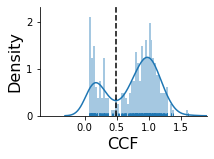

In [139]:
print('pt3, t1')
data = pt3_t1_df.copy(deep=False)

xlim2 = 1.9
yticks = np.arange (0, 3, 1)
xticks = np.arange(0, 2, 0.5)
density_plot_paper(data,'t_CCF',xlim1=-0.7,xlim2=xlim2,ylim1=0,ylim2=3,xticks=xticks,yticks=yticks,bins=50, position=1.2)        

plt.savefig('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt3/AQ5182_vs_AQ5176/pt3_t1_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

In [147]:
threshold = thresholds['pt3_t1']
print(threshold)
pt3_t1_df['clonal'] = pt3_t1_df['t_CCF'].apply(lambda x: True if x >= threshold else False)
pt3_t1_df[(pt3_t1_df['mut_type']=='snv')&(pt3_t1_df['gnomADg_AF']<1)].groupby('clonal').count()

0.4880408661925021


#CHROM  POS   ID  REF  ALT  QUAL  FILTER  INFO  FORMAT  NORMAL  ...  \
clonal                                                                  ...   
False       67   67   67   67   67    67      67    67      67      67  ...   
True       111  111  111  111  111   111     111   111     111     111  ...   

        PHENO  gnomADg  gnomADg_AF  gnomADg_NFE  subset_origin  SAMPLE   CN  \
clonal                                                                        
False      67       67          67           67             67      67   67   
True      111      111         111          111            111     111  111   

        t_CCF  n_CCF  purity  
clonal                        
False      67     67      67  
True      111    111     111  

[2 rows x 59 columns]

pt3, t2
0.16190883943755502 92
0.008305385048165843 161
0.8362790937332446 0.16190883943755502


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


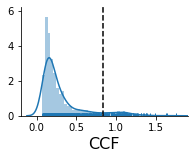

In [140]:
print('pt3, t2')
data = pt3_t2_df.copy(deep=False)

xlim2 = 1.9
yticks = np.arange (0, 6+1, 2)
xticks = np.arange(0, 2, 0.5)
density_plot_paper(data,'t_CCF',xlim1=-0.2,xlim2=xlim2,ylim1=0,ylim2=5,xticks=xticks,yticks=yticks,bins=50, position=1.2)        
plt.ylabel('')
plt.savefig('/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt3/AQ5188_vs_AQ5176/pt3_t2_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

In [148]:
threshold = thresholds['pt3_t2']
print(threshold)
pt3_t2_df['clonal'] = pt3_t2_df['t_CCF'].apply(lambda x: True if x >= threshold else False)
pt3_t2_df[(pt3_t2_df['mut_type']=='snv')&(pt3_t2_df['gnomADg_AF']<1)].groupby('clonal').count()

0.6594260071476463


#CHROM   POS    ID   REF   ALT  QUAL  FILTER  INFO  FORMAT  NORMAL  \
clonal                                                                       
False     1024  1024  1024  1024  1024  1024    1024  1024    1024    1024   
True        94    94    94    94    94    94      94    94      94      94   

        ...  PHENO  gnomADg  gnomADg_AF  gnomADg_NFE  subset_origin  SAMPLE  \
clonal  ...                                                                   
False   ...   1024     1024        1024         1024           1024    1024   
True    ...     94       94          94           94             94      94   

          CN  t_CCF  n_CCF  purity  
clonal                              
False   1024   1024   1024    1024  
True      94     94     94      94  

[2 rows x 59 columns]

pt1 _t1


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


0.029282567887728966 60
0.8682485982482773 0.029282567887728966
pt1 _t2
0.5199559994236825 0.15521740292456146
pt2 _t1


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

0.2015735714618885 83
0.6215705203892312 0.2015735714618885
pt2 _t2
0.02903031600255966 52
0.026523197868789514 69
0.9033595790612529 0.026523197868789514
pt3 _t1


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


0.3417430045392537 74
0.4821550513090136 0.3417430045392537
pt3 _t2
0.6689784329434348 0.2440558351255637


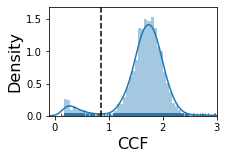

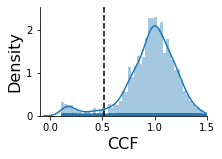

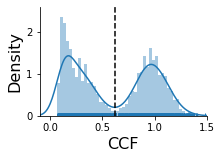

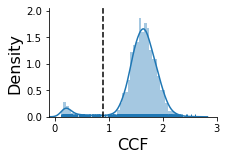

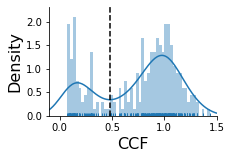

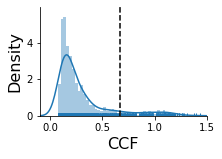

In [29]:

j = 0
for pt in ['pt1','pt2','pt3']:
    for tumor in ['_t1','_t2']:
        print(pt,tumor)
        if tumor == '_t1':
            title = 'Tumor 1'
        else:
            title = 'Tumor 2'
        sample_id = pt + tumor
        sample_df = samples_list[j]
        data = sample_df.copy(deep=False)
        if (pt == 'pt1' and tumor == '_t1') or (pt == 'pt2' and tumor == '_t2'):
            xlim2 = 3
        else:
            xlim2 = 1.5
        density_plot_paper(data,'t_CCF',xlim1=-0.1,xlim2=xlim2,bins=50, position=1.2,sample=sample_id)
        j = j +1
        

